<div style="text-align: right">  
Notebook by Ted Veldkamp and Marthe Wens <br>
</div>
Computer Exercise: Estimate drought hazard for Kenya under current and future conditions
============

In the lecture, you were taught about ways to estimate meteorological, agricultural, and hydrological drought hazard. Either by using standardized indicators (SPI, SPEI, SSFI) or by fixed or variable threshold level methods (Q90). In this practical, you will learn to apply both methods to calculate drought hazard for a particular location in Kenya, under historic and future time periods.

## Performing the exercise
You will do so by performing the scripts in this Python Jupyter notebook. To run any script in the code-boxes below use *crtl+enter*. In some instances, it is necessary to make changes to particular pieces of code in the code-boxes. When this is the case, this will be asked to you before you arrive at the actual script. This is indicated by means of an **action**. When a script is running this is indicated by the * on the left side of the window.

## Saving your results
Together with this Python Jupyter notebook an answer sheet in Word is shared with you. Make sure you safe the requested outputs (figures, tables) and answers to questions here. Furthermore, save the codes that you have created and run during this exercise and export it to an .pdf. You will do so by clicking in the menu (top/left) on "Download as .pdf".

## 1. Importing Python packages

Before running any Python script (in an offline or online modus) it is necessary to import a number of Python packages that can help you with performing the calculations. 

**action**: perform scripts below by selecting them and press *crt+enter* (this will not be mentioned anymore afterwards).

In [5]:
import xarray as xr
import numpy as np
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
#import gdal
#from osgeo import gdal, osr, ogr
import xlsxwriter
import pandas as pd
import os
os.chdir("G:/PhD/Projects/ASALI training/Practica")
workingfolder = os.getcwd()
inputfolder   = os.path.join(workingfolder,'input') 

In the data-folder a number of files have been prepared that serve as input for this exercise. First, open the .xlsx file itself and familiarize yourself with the data. Draw a few plots to see how the two climate change scenarios impact the hydrological variables at this specific point.

**action**: Make sure that you define to the correct path and file in the lines of code below. If needed, make changes to input_folder and infput_file. Afterwards run the code by pressing *ctrl+enter*.

In [7]:
# Name input file
weather_file  = os.path.join(inputfolder,'Point_Data_Kenya.xlsx')
print(weather_file)

G:\PhD\Projects\ASALI training\Practica\input\Point_Data_Kenya.xlsx


## 2: Loading and inspecting the input data

We will now start with loading and inspecting the input data within Python. To do so, we first need to define the start and end years for the historical and future time-periods. You will do this in the following code-box.

**action**: Define the start and end date for the historical and future time-periods. Use 2000/2001 as the division between historical and future conditions. Press *ctrl+enter* to run the code.

In [8]:
# Before running this code-box define the start and end date 
# for the historical and future time-periods

data_start = 1971
data_end   = 2050
years = data_end - data_start  

hist_start = 1971
hist_end   = 2000
years_h = hist_end - hist_start  
h_in = (hist_start-data_start)*12
h_out= (hist_end-hist_start)*12

fut_start = 2001
fut_end   = 2050
years_f = fut_end - fut_start  
f_in = (hist_start - data_start)*12
f_out= (fut_end-fut_start)*12

Once the start and end date for the historical and future time-periods are defined we can load the actual variables in order to perform drought hazard calculations. In the following code-box, we import the point-data from the Excel data-source and extract the different variables into new Python variables.

**action**: Inspect which variables are being imported and how this is done. Run the code by pressing *ctrl+enter*.

In [9]:
df = pd.read_excel(weather_file,sheet_name = 'RCP2p6', delimiter=',')

variables = {}   
variables['precipitation']      = df["Precipitation (mm)"].values
variables['evapotranspiration'] = df["Potential Evapotranspiration (mm)"].values
variables['runoff']             = df["Local_Runoff (mm)"].values
variables['discharge']          = df["Discharge (m3/sec)"].values
dates   = df["Date"]

df2 = pd.read_excel(weather_file,sheet_name = 'RCP6p0', delimiter=',')

variables2 = {}   
variables2['precipitation']      = df2["Precipitation (mm)"].values
variables2['evapotranspiration'] = df2["Potential Evapotranspiration (mm)"].values
variables2['runoff']             = df2["Local_Runoff (mm)"].values
variables2['discharge']          = df2["Discharge (m3/sec)"].values
dates   = df["Date"]

We have now loaded all necessary variables into Python. Perform the script below to check-out the imported time-series of hydrological variables. 

**action**: Inspect and run the code in the code-box below to make a plot for the Precipitation variable. Save the plot as an image and copy it into the Word-answer file under Figure 1. 

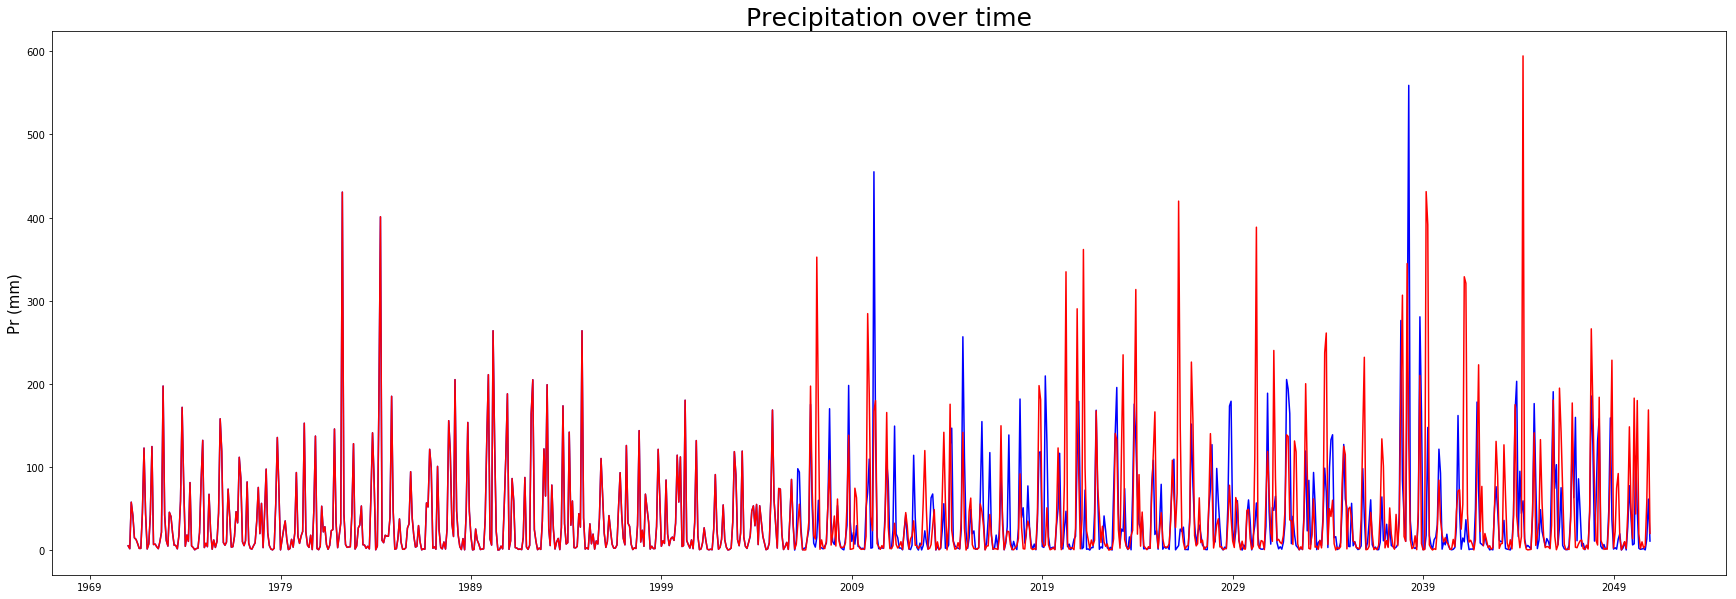

In [10]:
fig = plt.figure(figsize=(30,10) )
l1=plt.plot(dates,variables['precipitation'], color='b',label='RCP2.6')
l2=plt.plot(dates,variables2['precipitation'], color='r',label='RCP6.0')
plt.ylabel('Pr (mm)',size=15)
plt.title('Precipitation over time',size=25)
plt.show()

**action**: Copy and amend the code from the previous code-box and run it to generate a plot for the variable 'discharge'. Make sure that you also change the title and axis labels accordingy. Save the plot as an image and copy it into the Word-answer file under Figure 2.

$Marthe: Deze code hieronder moet worden gedelete voor gebruik.

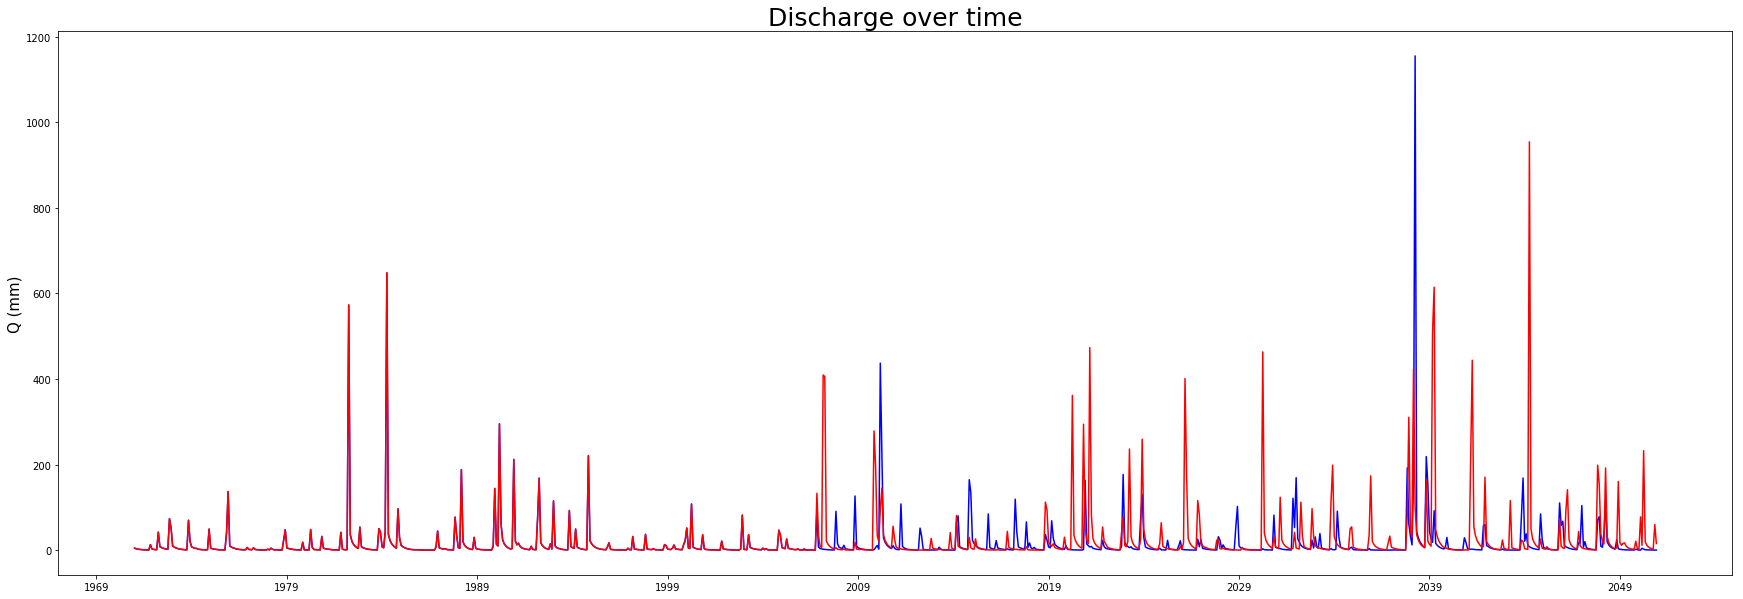

In [12]:
fig = plt.figure(figsize=(30,10) )
l1=plt.plot(dates,variables['discharge'], color='b',label='RCP2.6')
l2=plt.plot(dates,variables2['discharge'], color='r',label='RCP6.0')
plt.ylabel('Q (mm)',size=15)
plt.title('Discharge over time',size=25)
plt.show()

**Question 1**: Briefly explain what we see in the two graphs that you just have copied to figure 1 and 2 of the Word-Answer sheet. 

## 3: Calculating meteorological drought conditions using standardized drought indicators

The required data-sets are now loaded correctly into Python. From this point on we will start with the actual drought calculation, beginning with meteorological drought. In this practical, we will calculate meteorological droughts (SPI) for two accumulation periods: 1 and 3 months. Drought conditions are being calculated for each month (using all January’s, February’s, etc). In order to do so, we make use of statistical distribution fitting techniques. By normalizing the fitted data afterwards drought conditions become comparable between different locations and for different months. The result of this procedure are meteorological or hydrological conditions that vary from ~ -3 (extremely dry) to ~ +3 (extremely wet compared to the long-term mean average conditions). The frequency, average duration, and severity of drought events are subsequently estimated by looking at the ‘clustered nature’ of individual drought months. 

### 3a: Select monthly preciptiation values for the historic time period

We will perform this exercise using historical data only. Hence, we need to  prepare a dataset with only historical values first. Do so, by running the code in the code-box below.

**action**: Run the code in the code-box below by pressing *ctrl+enter*.

In [13]:
hist_dataseries = variables['precipitation'][h_in:h_out]     

### 3b: Prepare accumulated precipitation time series for the historic time period

Before starting with the SPI calculation we need to prepare the accumulated time-series first. In this example by using a lag time of 1 month. 

In [14]:
# Choose accumulation time
accumulationtime = 1   
accumulatedvariables = {}

# Function to calculate accumulation of precipitation over months
accumulated_precipitation = np.cumsum(hist_dataseries, dtype=float)                 
accumulated_precipitation[accumulationtime:] = accumulated_precipitation[accumulationtime:] - accumulated_precipitation[:-accumulationtime]         
accumulated_precipitation[:accumulationtime - 1] = np.nan    

### 3c: Select preciptiation values of a certain month for the historic time period
Subsequently, we will start with calculating the SPI-1 conditions for a selected month (here: October (m=10)). 

**action**: Define the correct month-number below and allign the time-series of accumulated precipitation. Run the code by pressing *ctrl+enter*.

In [15]:
month = 1

accumulated_precipitation_month = np.zeros(years_h-1)
for yr in range(1,int(years_h)):    
    accumulated_precipitation_month[yr-1] = accumulated_precipitation[(12*yr)+month]
print('monthly accumulated precipitation:\n',accumulated_precipitation_month)

monthly accumulated precipitation:
 [ 7.53944712  4.92031451 18.2233719   8.29467886  5.92405177  5.4577018
  3.04513845 12.66332431 17.21115533  4.68428294 17.90502603 26.79255232
  4.82077935  1.79511561  3.6824151   3.87081668 16.43083956  0.33652094
  6.10419151 11.31895452  5.83024158 26.07923769  9.06865142  2.80723597
  3.36000595  6.4451467   4.61543742 11.33998969]


**Question 2**: What do the numbers presented in the above-mentioned results box mean? Give this answer under Question 1 in the Word-answer file. 

Take a close look at the following code-boxes (3c.I-3c.III) to better understand the different steps that need to be taken for the SPI-1 drought calculation. Then run the code by pressing *ctrl+enter*.

In [16]:
# 3c.I Find the appropriate distribution parameters of the Gamma function      
dist = getattr(stats, 'gamma')
param = dist.fit(accumulated_precipitation_month)
rv = dist(*param)    

**Question 3**: Which statistical distribution is being used to fit a distribution through the data-points in order to calculate SPI-1 conditions?

In [17]:
# 3c.II Assess the goodness-of-fit using Kolmogorov–Smirnov test
D, p = stats.kstest(accumulated_precipitation_month, 'gamma', args=param)                    
print('pvalue: ',p)

pvalue:  0.7244091387289471


**Question 4**: Look-up what the goodness-of-fit test in the code-box 3c.II actually tests and discuss whether the presented pvalue is sufficient.

In [18]:
# 3c.III Account for zero values (cfr.Stagge et al. 2015)  
nyears_zero = len(accumulated_precipitation_month) - np.count_nonzero(accumulated_precipitation_month)
p_zero = nyears_zero / len(accumulated_precipitation_month)
p_zero_mean = (nyears_zero + 1) / (2 * (len(accumulated_precipitation_month) + 1))           
ppd = (accumulated_precipitation_month * 0 ) + p_zero_mean
ppd[np.nonzero(accumulated_precipitation_month)] = p_zero+((1-p_zero)*rv.cdf(accumulated_precipitation_month[np.nonzero(accumulated_precipitation_month)]))

**Question 5**: Explain in your own words what we do when we account for zero values.

Run the code under 3c.IV to plot the Gamma distribution using the precipitation dataset in order to resemble Figure 7 from Van Loon et al. (2015) (see below). Make sure you add the right title and labels for the axes.

**action**: Inspect the code in code-box 3c.IV, change the label and title names, and run the code. Save the plot as an image and copy it into the Word-answer file under Figure 3a (left-side).

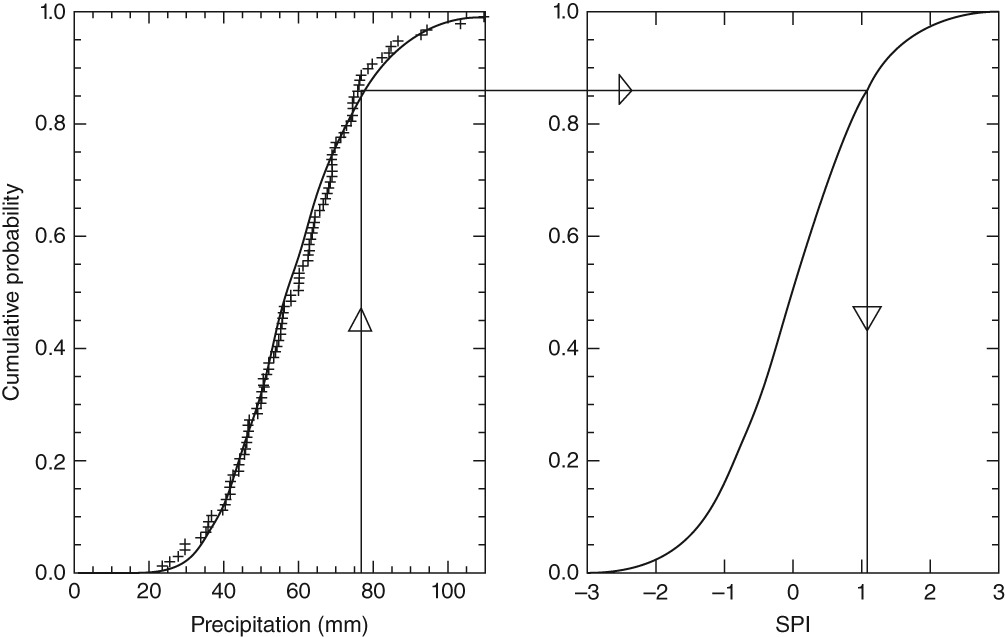

In [23]:
from IPython.display import Image
Image("VanLoon2015fig7.jpg")

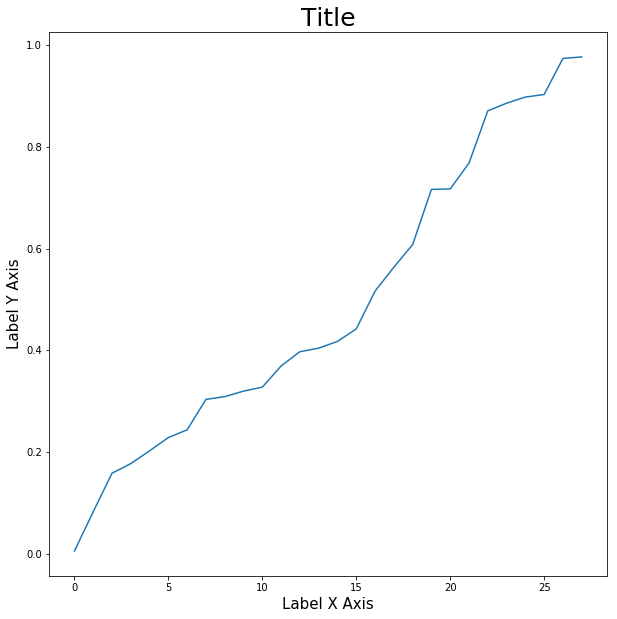

In [24]:
# 3c.IV Plot the cummulative distribution function for the SPI-1
fig = plt.figure(figsize=(10,10) )
plt.plot(np.sort(ppd))
plt.ylabel('Label Y Axis',size=15)
plt.xlabel('Label X Axis',size=15)
plt.title('Title',size=25)
plt.show()   

Run the code in code-box 3c.V  to transform the values back into a standard-normal distribution that is being used to present eventually SPI-1 values.  

In [25]:
# 3c.V Standardize the fitted cummulative distribtuion distribution  
z_month = stats.norm.ppf(ppd)                                   
z_month[z_month>3] = 3
z_month[z_month<-3] = -3 
print('SPI values of one month:\n',z_month)

SPI values of one month:
 [ 0.04144986 -0.44548635  1.29705871  0.1596976  -0.24158363 -0.33306281
 -0.92368517  0.73182568  1.20326668 -0.49759281  1.26792168  1.98554007
 -0.46724105 -1.38262795 -0.74210109 -0.69279013  1.12856295 -2.50832003
 -0.20758091  0.57188121 -0.25957415  1.93393153  0.273603   -0.99855912
 -0.83085893 -0.14506765 -0.51313792  0.57447661]


Run the code in code-box 3c.VI to plot a figure that resembles figure 7 (right) from Van Loon et al. (2015). Make sure you add the right title and labels for the axes.

**action**: Inspect the code, change the label and title names and run the code to make the plot. Save the plot as an image and copy it into the Word-answer file under Figure 3b (right side).

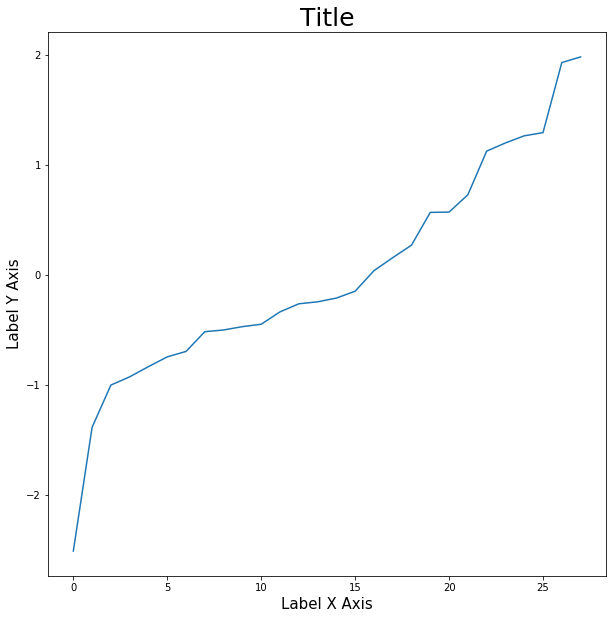

In [26]:
# 3c.VI Plot SPI function
fig = plt.figure(figsize=(10,10) )
plt.plot(np.sort(z_month))
plt.ylabel('Label Y Axis',size=15)
plt.xlabel('Label X Axis',size=15)
plt.title('Title',size=25)
plt.show()  

**Question 6**: Look up, by using the plots 3a and 3b, which amount of mm (~) corresponds to a SPI-1 level of -1. And which probability (~) belongs to these values? Given that we calculated SPI-1 levels, how should we interpret the mm value?

Run the code-box below to plot the SPI-1 values of the month selected initially (October) in a time-series plot and add correct title and labels for the Y-axis.

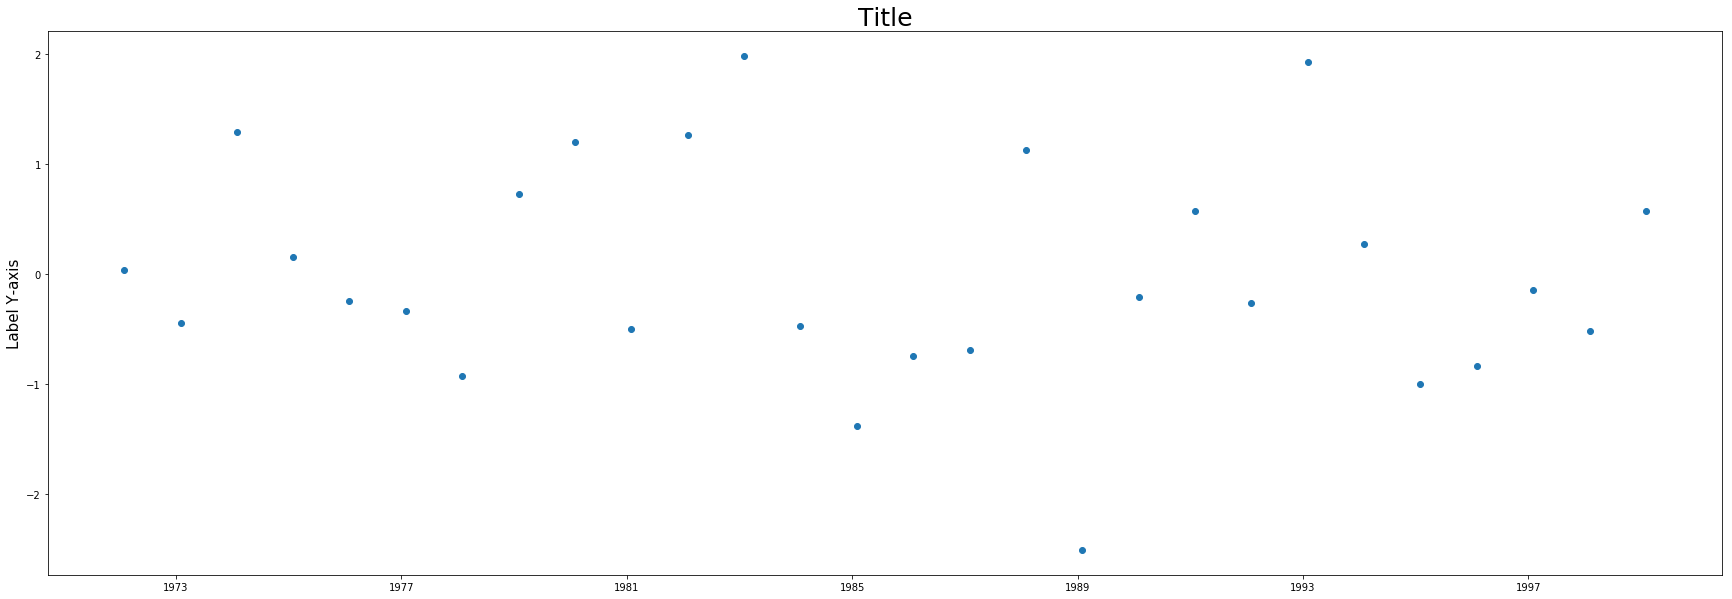

In [27]:
# Bring the SPI values back in their right spot in the historic time series
indexvalues_month = hist_dataseries * np.nan
for yr in range(1,years_h):
    indexvalues_month[(12*yr)+month] = z_month[yr-1]
    
#Plot the calculated SPI values over time
fig = plt.figure(figsize=(30,10) )
plt.plot(dates[h_in:h_out],indexvalues_month,"o")
plt.ylabel('Label Y-axis',size=15)
plt.title('Title',size=25)
plt.show()

### 3d: SPI-1 calculation for each month over the historic time-period 
we will now repeat the above-mentioned steps for all months throughout the year (m=1:12). Take a careful look how we do this by inspecting code-boxed 3d.I-3d.V and run the code in the code-boxes below to eventually plot the SPI-1 values for all months. Where needed, change the names of titles and axis. 

**action**: Save the generated plot under Figure 4 in the Word-answer sheet.


In [28]:
# 3d.I Extract historic data
hist_dataseries = variables['precipitation'][h_in:h_out]     

In [29]:
# 3d.II Prepare empty dataset for SPI-1 values to be stored
SPI1 = np.zeros(hist_dataseries.shape)

In [30]:
# 3d.III Create accumulated data time-series
accumulationtime = 1   
cummuldata = np.cumsum(hist_dataseries, dtype=float)                 
cummuldata[accumulationtime:] = cummuldata[accumulationtime:] - cummuldata[:-accumulationtime]         
cummuldata[:accumulationtime - 1] = np.nan                                           
cummul_hist_dataseries = cummuldata  

In [31]:
# 3d.IV loop over all months to calculate SPI-1 per month
for m in range(12):
    
    # Extract values per month, ignore first, incomplete year
    values = np.zeros(years_h-1)
    for yr in range(1,years_h):     
        values[yr-1] = hist_dataseries[(12*yr)+m]

    # Find distribution parameters of Gamma function      
    dist = getattr(stats, 'gamma')
    param = dist.fit(values)
    rv = dist(*param)   
    
    # Account for zero values (cfr.Stagge et al. 2015)  
    nyears_zero = len(values) - np.count_nonzero(values)
    p_zero = nyears_zero / len(values)
    p_zero_mean = (nyears_zero + 1) / (2 * (len(values) + 1))           
    ppd = (values * 0 ) + p_zero_mean
    ppd[np.nonzero(values)] = p_zero+((1-p_zero)*rv.cdf(values[np.nonzero(values)]))
    
    # Standardize the cummulative distribution function
    z = stats.norm.ppf(ppd)                                   
    z[z>3] = 3
    z[z<-3] = -3 
    
    # Bring the SPI values back in their right spot in the time series
    for yr in range(1,years_h):
        SPI1[(12*yr)+m] = z[yr-1]      

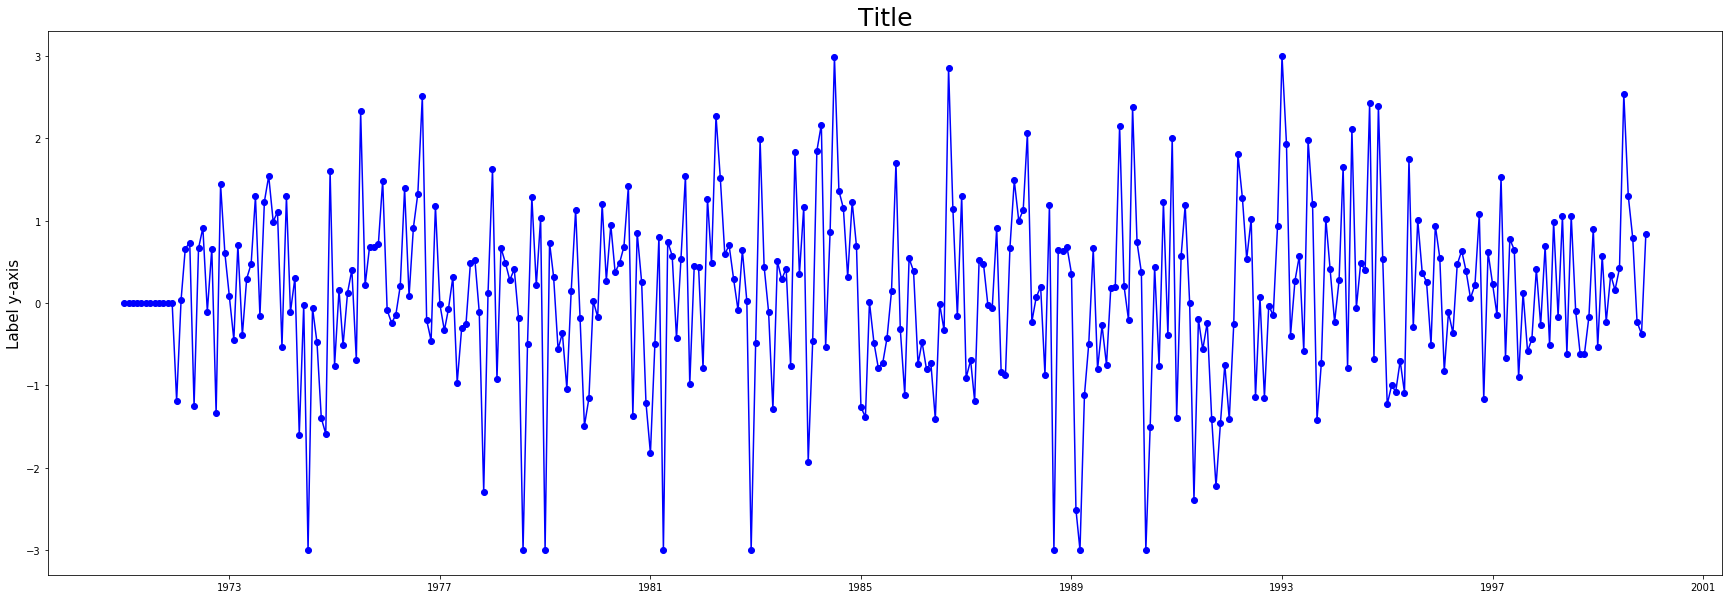

In [32]:
# 3d.V Plot the calculated SPI-1 values over time
fig = plt.figure(figsize=(30,10) )
plt.plot(dates[h_in:h_out],SPI1,"-o",color='b')
plt.ylabel('Label y-axis',size=15)
plt.title('Title',size=25)
plt.show()

### 3e: SPI-6 calculation for each month over the historic time-period 
Repeat now the steps under 3d to calculate SPI-6 for each month over the historic time-period. Do this by copying, amending the codes from the previous boxes in the empty code-boxes below. Then run the code to generate the plot. Eventually, save the plot under Figure 5 in the Word-answer sheet

$Marthe: Na testen moet de code (niet de #) uit de code-boxes hieronder worlen gedelete

In [33]:
# 3e.I Extract historic data
hist_dataseries = variables['precipitation'][h_in:h_out]     

In [34]:
# 3e.II Prepare empty dataset for SPI-1 values to be stored
SPI6 = np.zeros(hist_dataseries.shape)

In [35]:
# 3e.III Create accumulated data time-series
accumulationtime = 6 
cummuldata = np.cumsum(hist_dataseries, dtype=float)                 
cummuldata[accumulationtime:] = cummuldata[accumulationtime:] - cummuldata[:-accumulationtime]         
cummuldata[:accumulationtime - 1] = np.nan                                           
cummul_hist_dataseries = cummuldata  

In [36]:
# 3e.IV loop over all months to calculate SPI-6 per month
for m in range(12):
    
    # Extract values per month, ignore first, incomplete year
    values = np.zeros(years_h-1)
    for yr in range(1,years_h):     
        values[yr-1] = cummul_hist_dataseries[(12*yr)+m]

    # Find distribution parameters of Gamma function      
    dist = getattr(stats, 'gamma')
    param = dist.fit(values)
    rv = dist(*param)   
    
    # Solve issue with zero values in Gamma distribution (cfr.Stagge et al. 2015)  
    nyears_zero = len(values) - np.count_nonzero(values)
    p_zero = nyears_zero / len(values)
    p_zero_mean = (nyears_zero + 1) / (2 * (len(values) + 1))           
    ppd = (values * 0 ) + p_zero_mean
    ppd[np.nonzero(values)] = p_zero+((1-p_zero)*rv.cdf(values[np.nonzero(values)]))
    
    # Standardize the cummulative distribution function
    z = stats.norm.ppf(ppd)                                   
    z[z>3] = 3
    z[z<-3] = -3 
    
    # Bring the SPI values back in their right spot in the time series
    for yr in range(1,years_h):
        SPI6[(12*yr)+m] = z[yr-1]   

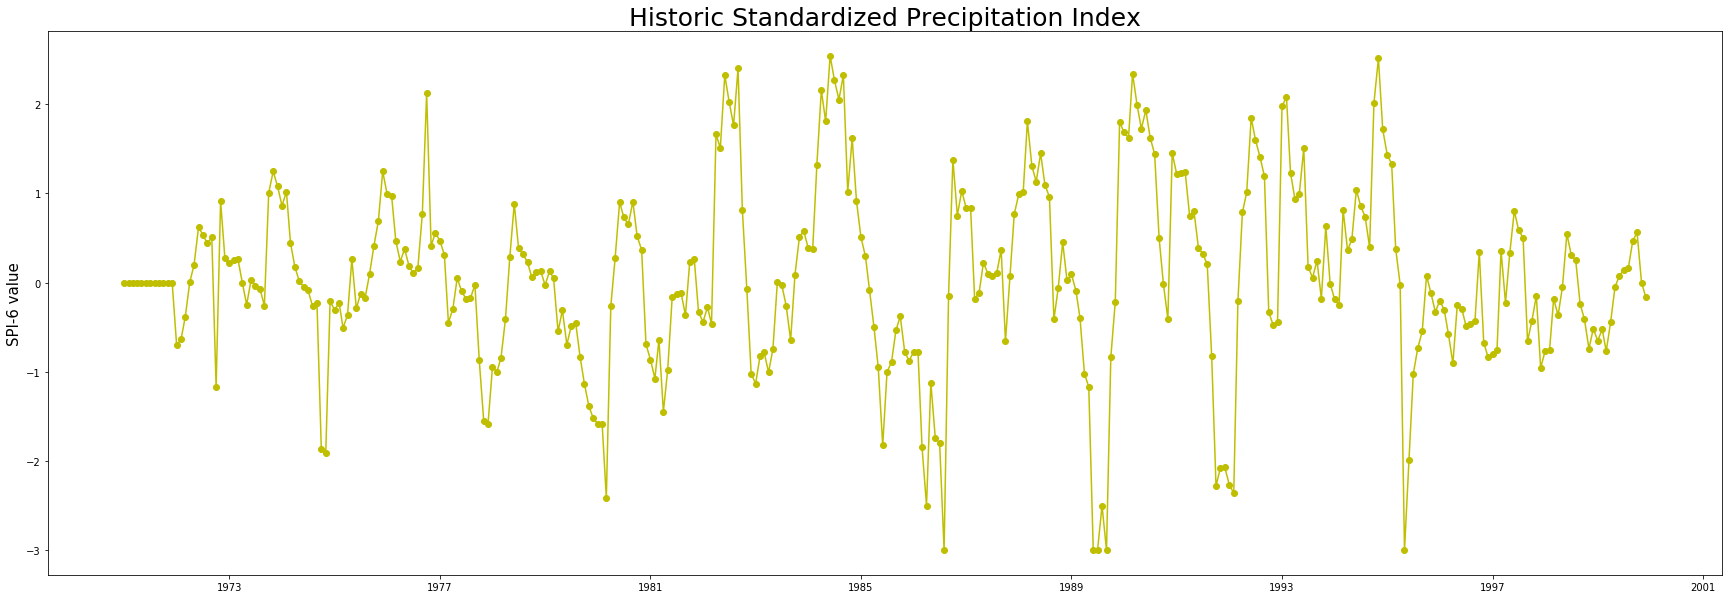

In [37]:
# 3e.V Plot the calculated SPI-6 values over time
fig = plt.figure(figsize=(30,10) )
plt.plot(dates[h_in:h_out],SPI6,"-o",color='y')
plt.ylabel('SPI-6 value',size=15)
plt.title('Historic Standardized Precipitation Index',size=25)
plt.show()

## 4: Evaluate meteorological drought conditions under historical periods 
Take a close look on how we evaluate subsequently the drought frequency and average duration in the following code-boxes (4.I-4.V) and run the code repeatedly in all the code-boxes using the different threshold values (-1, -1.5, -2) for the SPI-1 and SPI-6 drought data. Paste the answers in a table in your Word-Answer sheet under Table 1. 

**action**: Run the codes 4.I - 4.V to evaluate drought frequency, duration, and number of drought events. Take over the values you find for the different thresholds in Table 1. Plot the graphs by running the code in code-box 4.V. Save the graph under Figure 6 in the Word-Answer sheet.

In [38]:
# 4.I Define drought threshold for which droughts are being identified
threshold = -1 
thresholds = SPI1 * 0 + threshold

dSPI1 = np.zeros(SPI1.shape)
dSPI1[SPI1<threshold] = 1
dSPI6 = np.zeros(SPI1.shape)
dSPI6[SPI6<threshold] = 1

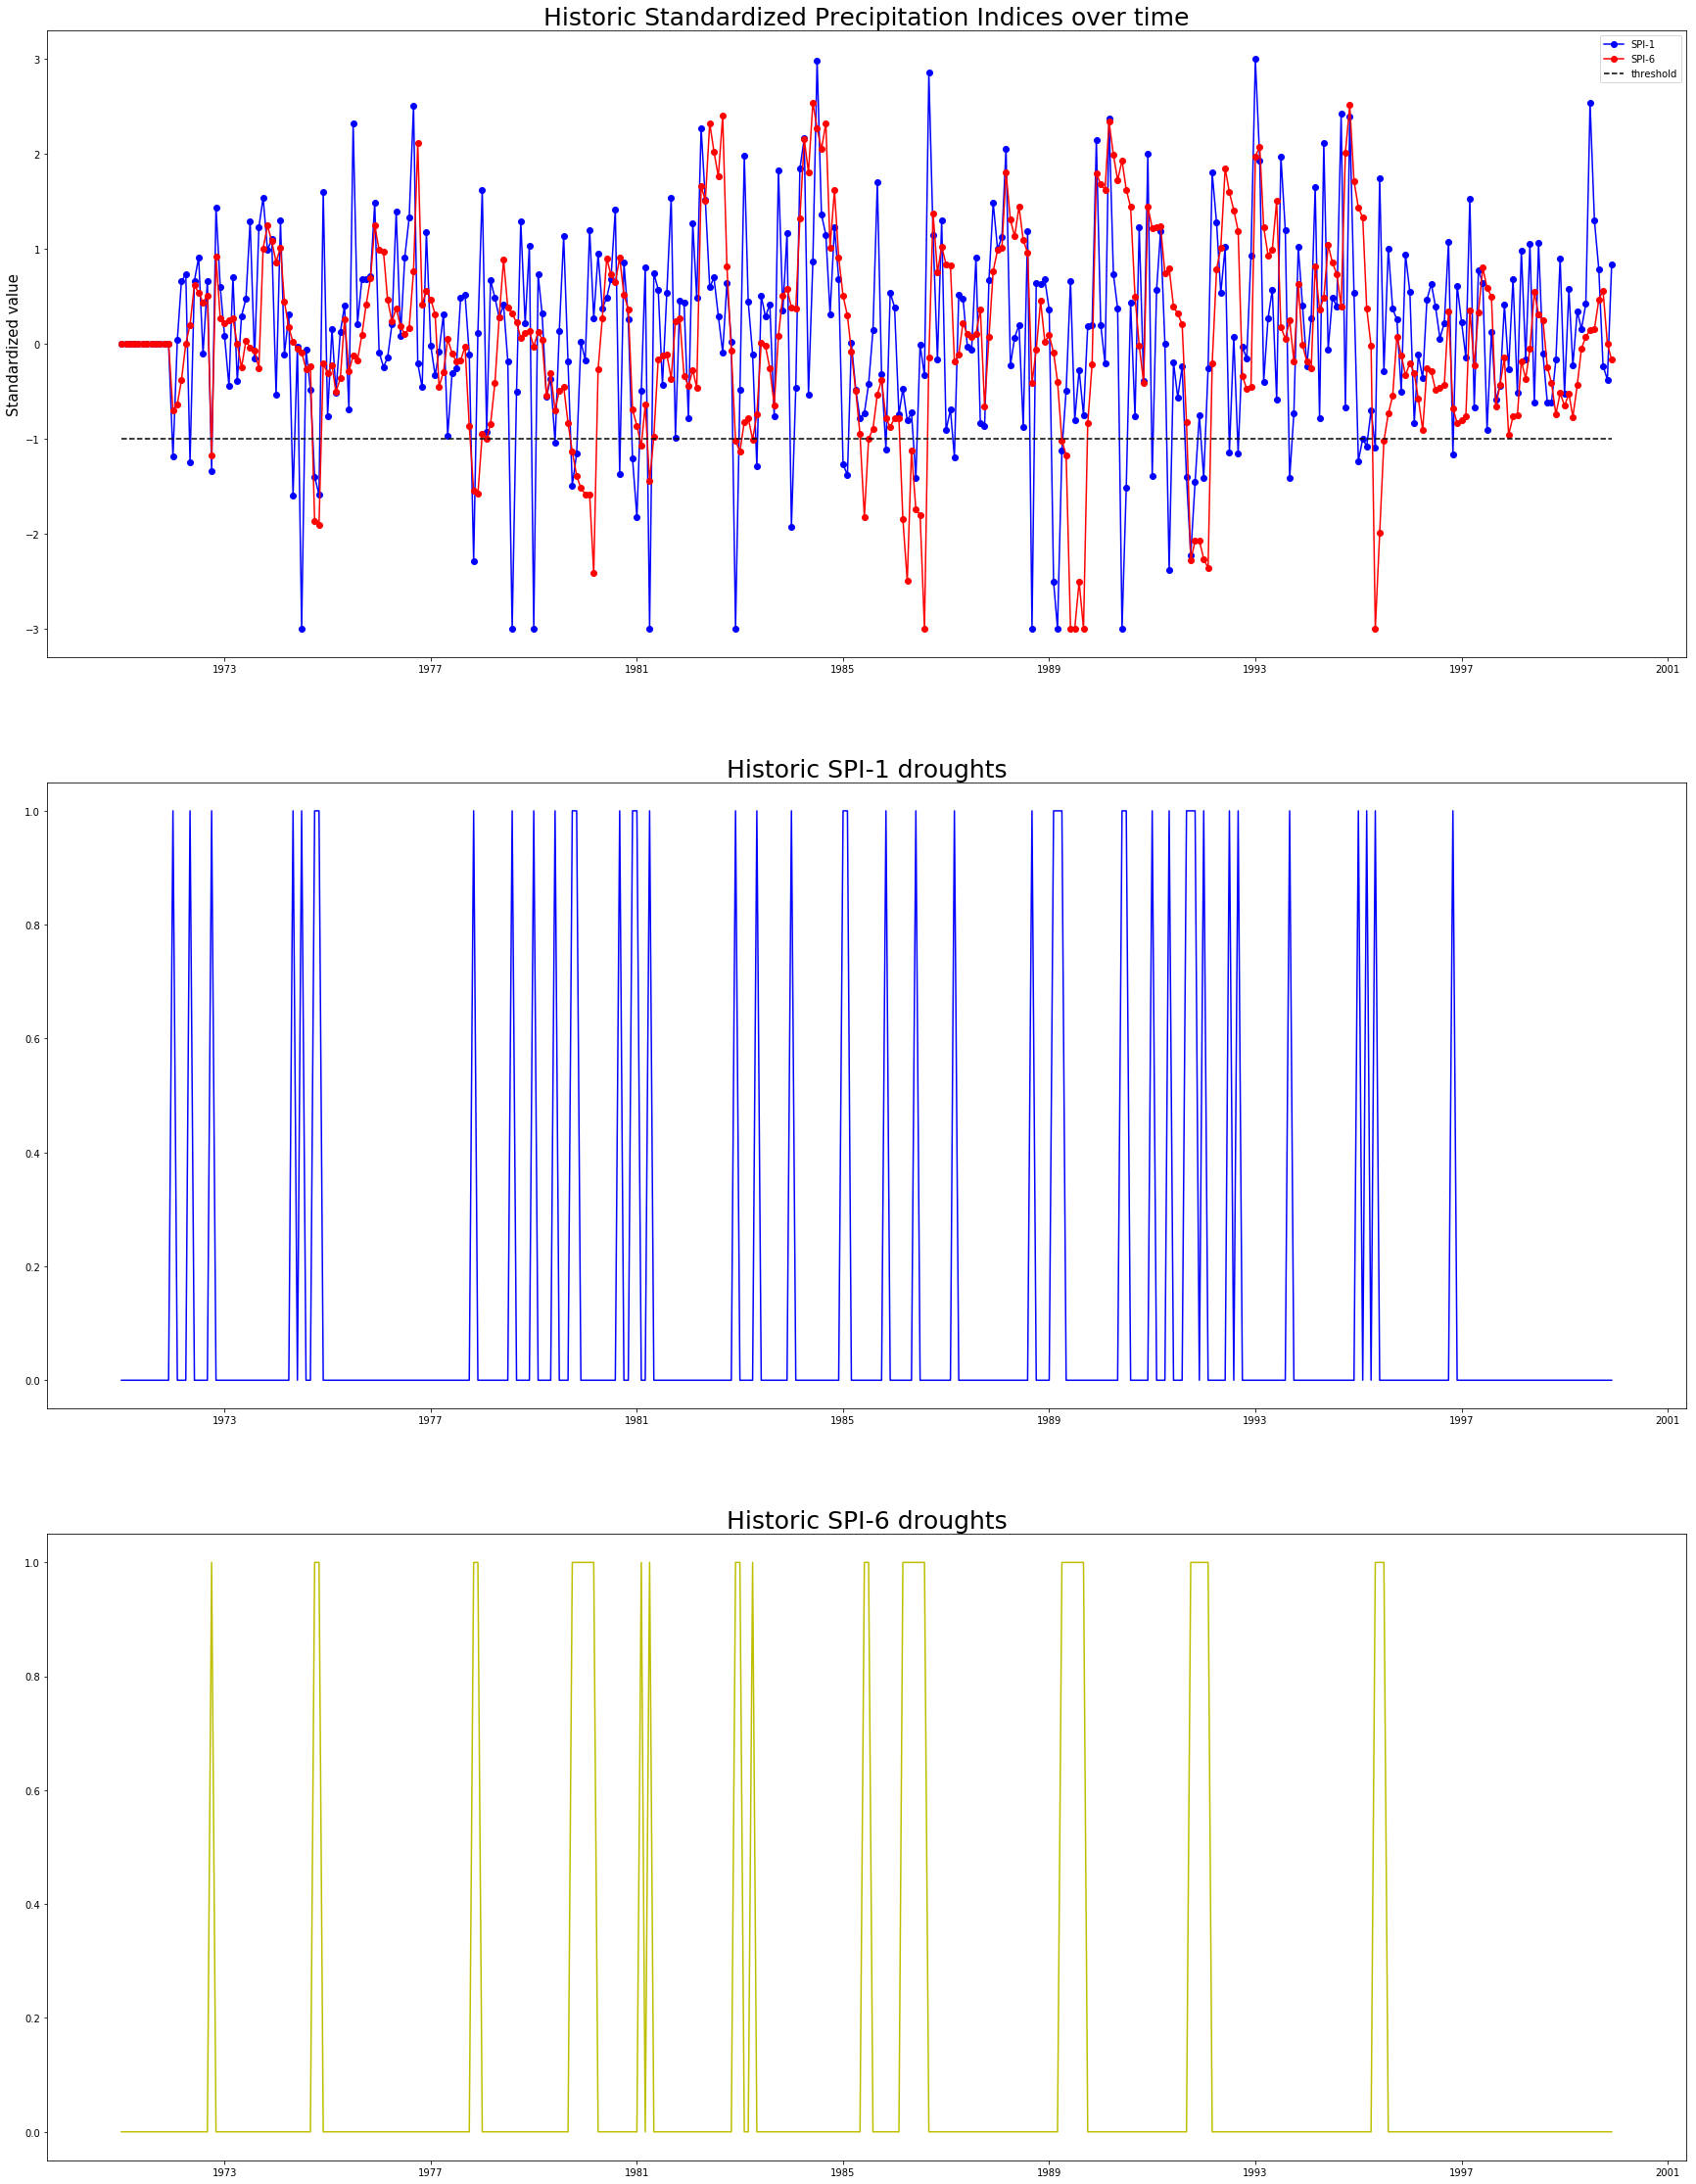

In [39]:
# 4.II Plot time-series of SPI values and drought conditions
fig = plt.figure(figsize=(30,40) )

plt.subplot(3, 1, 1)
l1=plt.plot(dates[h_in:h_out],SPI1,"-o", color='b',label='SPI-1')
l2=plt.plot(dates[h_in:h_out],SPI6,"-o", color='r',label='SPI-6')
l3=plt.plot(dates[h_in:h_out],thresholds,"--", color='k',label='threshold')
plt.ylabel('Standardized value',size=15)
plt.title('Historic Standardized Precipitation Indices over time',size=25)
plt.legend()#(l1,l3,l4), ('SPI-1', 'SPI-6','drought threshold'),'upper left')

plt.subplot(3, 1, 2)
plt.plot(dates[h_in:h_out],dSPI1, color='b')
plt.title('Historic SPI-1 droughts',size=25)

plt.subplot(3, 1, 3)
plt.plot(dates[h_in:h_out],dSPI6, color='y')
plt.title('Historic SPI-6 droughts',size=25)

plt.show()

In [40]:
# 4.III Analyze the total number of drought months for SPI-1 and SPI-6
print('# months under SPI-1 drought conditions: ',np.sum(dSPI1))
print('# months under SPI-6 drought conditions: ',np.sum(dSPI6))

# months under SPI-1 drought conditions:  44.0
# months under SPI-6 drought conditions:  38.0


In [41]:
# 4.IV Analyze the average drought duration for SPI-1 and SPI-6
SPI1propagation = SPI1 * 0
for t in range(len(SPI1)):
    if SPI1[t] <= threshold:
        SPI1propagation[t] = SPI1propagation[t-1] + 1
        SPI1propagation[t-1] = 0
    else:
        SPI1propagation[t] = 0
print('average duration SPI-1 drought conditions: ',np.mean(SPI1propagation[SPI1propagation>0]),' months')

SPI6propagation = SPI6 * 0
for t in range(len(SPI6)):
    if SPI6[t] <= threshold:
        SPI6propagation[t] = SPI6propagation[t-1] + 1
        SPI6propagation[t-1] = 0
    else:
        SPI6propagation[t] = 0
print('average duration SPI-6 drought conditions: ',np.mean(SPI6propagation[SPI6propagation>0]),' months')


average duration SPI-1 drought conditions:  1.2571428571428571  months
average duration SPI-6 drought conditions:  2.923076923076923  months


In [42]:
# 4.V Analyze the total number of drought events
SPI1propagation[SPI1propagation>0] = 1
print('number of SPI-1 droughts: ',np.sum(SPI1propagation))
SPI6propagation[SPI6propagation>0] = 1
print('number of SPI-6 droughts: ',np.sum(SPI6propagation))

number of SPI-1 droughts:  35.0
number of SPI-6 droughts:  13.0


**Question 7**: Describe what occurs with the number of drought months, the number of drought events, and the duration of drought events when using different threshold values and the SPI-1 and SPI-6 time-series. How should we interpret the changes when using different thresholds?

## 5: Calculating agricultural drought conditions using standardized drought indicators: SPEI-1 and SPEI-6 for the historical conditions
So far, we only used precipitation to estimate drought conditions. In this section we will also use potential evapotranspiration to estimate agricultural drought conditions, using SPEI. 

### 5a: SPEI-1 drought calculation for each month over the historic time-period¶

Take a close look at the code boxes 5a.I-5a.V and run the scripts to calculate SPEI-1 and plot the data. 

**action**: Plot the result under Figure 7 of your Word-Answer sheet.

In [43]:
# 5a.I Extract historic precipitation minus evapotranspiration data
hist_dataseries = variables['precipitation'][h_in:h_out] - variables['evapotranspiration'][h_in:h_out]   

In [44]:
# 5a.II Create an empty data-set
SPEI1 = np.zeros(hist_dataseries.shape)

In [45]:
# 5a.III Define accumulation time and create accumulated data time-series
accumulationtime = 1
cummuldata = np.cumsum(hist_dataseries, dtype=float)                 
cummuldata[accumulationtime:] = cummuldata[accumulationtime:] - cummuldata[:-accumulationtime]         
cummuldata[:accumulationtime - 1] = np.nan                                           
cummul_hist_dataseries = cummuldata  

In [46]:
# 5a.IV loop over all months to calculate SPEI-1 per month
for m in range(12):
    
    # Extract values per month, ignore first, incomplete year
    values = np.zeros(years_h-1)
    for yr in range(1,years_h):     
        values[yr-1] = cummul_hist_dataseries[(12*yr)+m]

    # Find distribution parameters of Gamma function      
    dist = getattr(stats, 'genextreme')
    param = dist.fit(values)
    rv = dist(*param)   
    
    # Account for zero values   
    nyears_zero = len(values) - np.count_nonzero(values)
    p_zero = nyears_zero / len(values)
    p_zero_mean = (nyears_zero + 1) / (2 * (len(values) + 1))           
    ppd = (values * 0 ) + p_zero_mean
    ppd[np.nonzero(values)] = p_zero+((1-p_zero)*rv.cdf(values[np.nonzero(values)]))
    
    # Standardize the cummulative distribution function
    z = stats.norm.ppf(ppd)                                   
    z[z>3] = 3
    z[z<-3] = -3 
    
    # Bring the SPI values back in their right spot in the time series
    for yr in range(1,years_h):
        SPEI1[(12*yr)+m] = z[yr-1]  

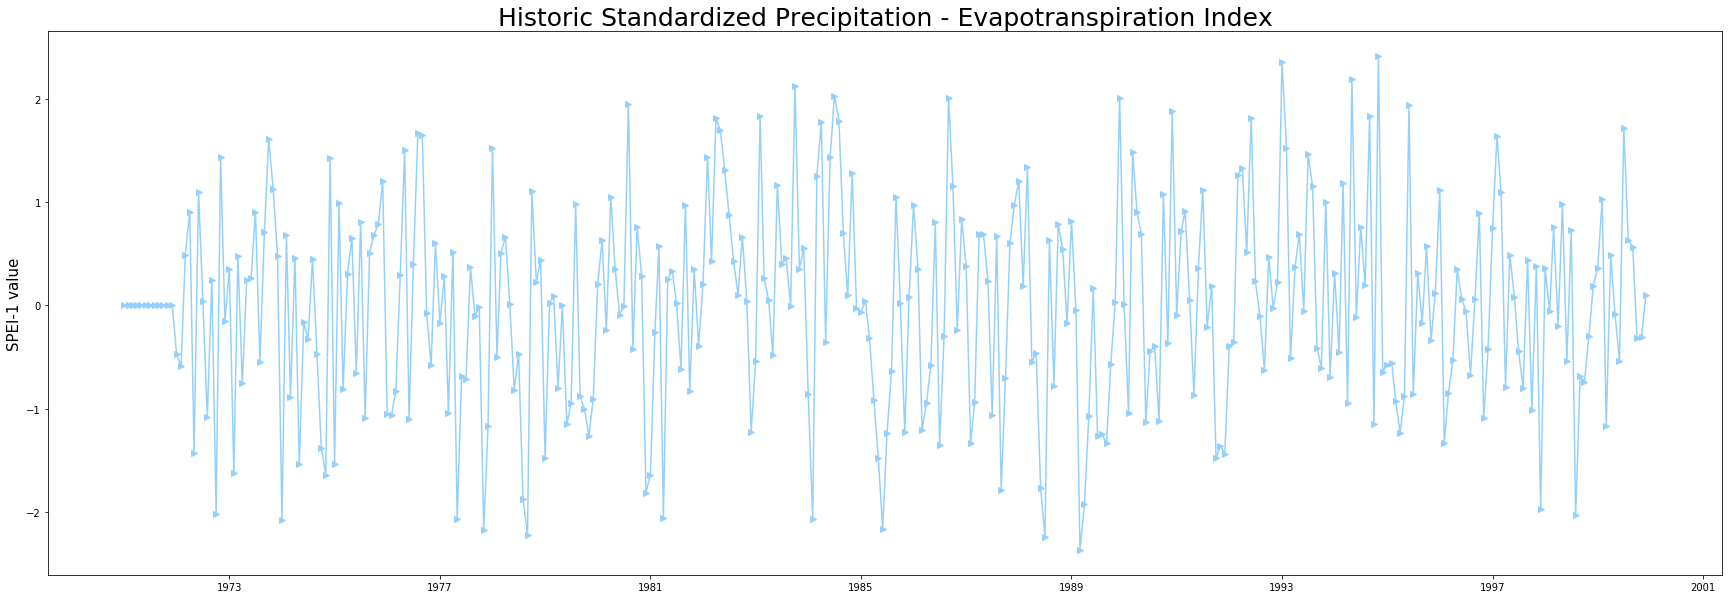

In [47]:
# 5a.V Plot the calculated SPEI-1 values over time
fig = plt.figure(figsize=(30,10) )
plt.plot(dates[h_in:h_out],SPEI1,"->",color='#95d0fc')
plt.ylabel('SPEI-1 value',size=15)
plt.title('Historic Standardized Precipitation - Evapotranspiration Index',size=25)
plt.show()

**Question 8**: What are the two main differences in the calculation methods of SPI and SPEI? How can we see these differences being coded when comparing code-boxes 3.I - 3.V with 5a.I - 5a.V

### 5b: SPEI-6 drought calculation for each month over the historic time-period 
We would also like to calculate SPEI-6 for each month over the historic time-period. Similarly to the SPI-6 calculations, copy and amend the code from the previous code-boxes and run them to calculate and plot SPEI-6.

**action**: Take over and amend the code to calculate SPEI-6 drought conditions. Make the plot, save it, and store it as Figure 8 in the Word-Answer sheet.

$Marthe: ook hier moeten de code-lijnen in de boxen worden gedelete voordat de opdracht gedistribueerd wordt. Staat er nu nog in voor testing. 

In [48]:
# 5b.I Extract historic precipitation minus evapotranspiration data
hist_dataseries = variables['precipitation'][h_in:h_out]  - variables['evapotranspiration'][h_in:h_out]    

In [49]:
# 5b.II Create an empty dataset
SPEI6 = np.zeros(hist_dataseries.shape)

In [50]:
# 5b.III Define accumulation time period and create accumulated data
accumulationtime = 6   
cummuldata = np.cumsum(hist_dataseries, dtype=float)                 
cummuldata[accumulationtime:] = cummuldata[accumulationtime:] - cummuldata[:-accumulationtime]         
cummuldata[:accumulationtime - 1] = np.nan                                           
cummul_hist_dataseries = cummuldata  

In [51]:
# 5b.IV loop over all months to calculate SPEI-6 per month
for m in range(12):
    
    # Extract values per month, ignore first, incomplete year
    values = np.zeros(years_h-1)
    for yr in range(1,years_h):     
        values[yr-1] = cummul_hist_dataseries[(12*yr)+m]

    # Find distribution parameters of Gamma function      
    dist = getattr(stats, 'genextreme')
    param = dist.fit(values)
    rv = dist(*param)   
    
    # Account for zero values   
    nyears_zero = len(values) - np.count_nonzero(values)
    p_zero = nyears_zero / len(values)
    p_zero_mean = (nyears_zero + 1) / (2 * (len(values) + 1))           
    ppd = (values * 0 ) + p_zero_mean
    ppd[np.nonzero(values)] = p_zero+((1-p_zero)*rv.cdf(values[np.nonzero(values)]))
    
    # Standardize the cummulative distribution function
    z = stats.norm.ppf(ppd)                                   
    z[z>3] = 3
    z[z<-3] = -3 
    
    # Bring the SPEI values back in their right spot in the time series
    for yr in range(1,years_h):
        SPEI6[(12*yr)+m] = z[yr-1]  

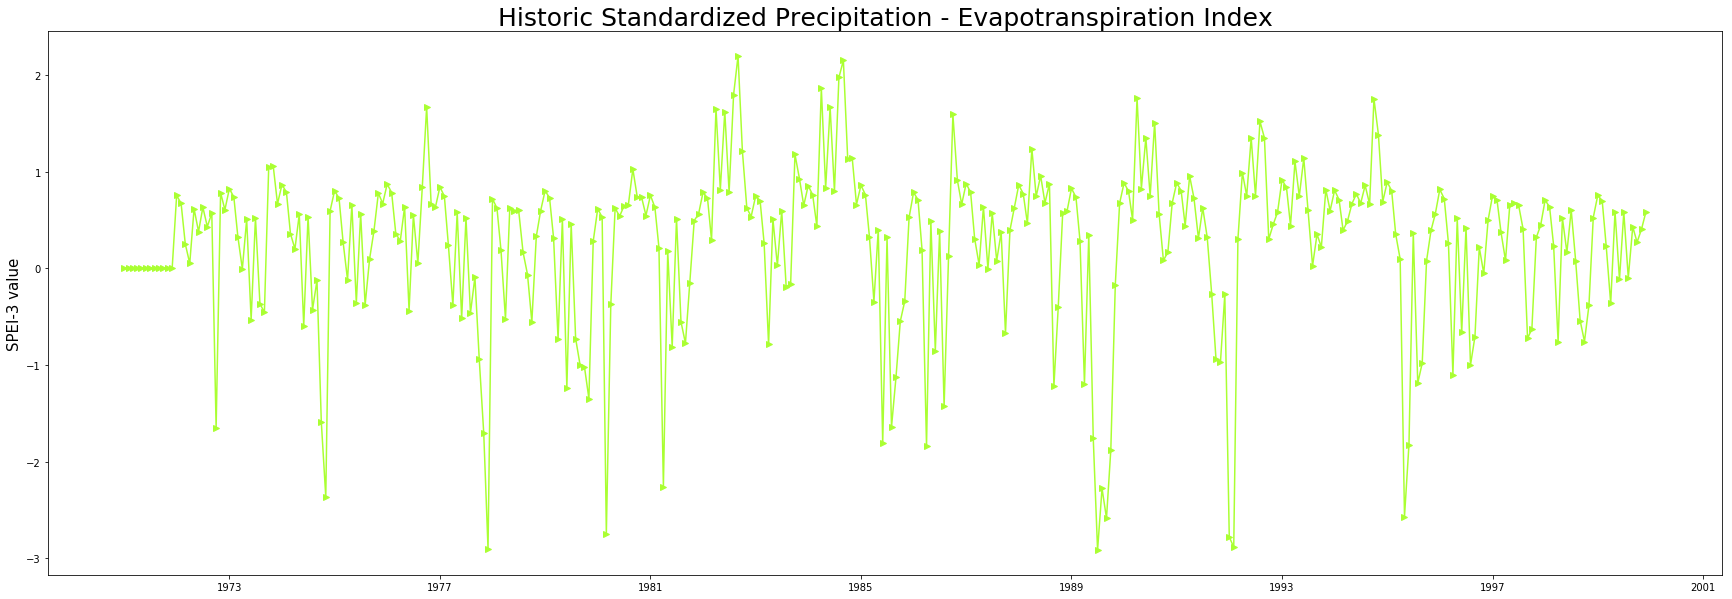

In [52]:
# 5b.V Plot the calculated SPEI-6 values over time
fig = plt.figure(figsize=(30,10) )
plt.plot(dates[h_in:h_out],SPEI6,"->",color='#aaff32')
plt.ylabel('SPEI-3 value',size=15)
plt.title('Historic Standardized Precipitation - Evapotranspiration Index',size=25)
plt.show()

## 6: Calculating hydrological drought conditions using standardized drought indicators: SSFI-1 and SSFI-6 for the historical conditions
Finally we would also like to compute SSFI-1 and SSFI6 for each month over the historic time-periods. 

**Question 9**: What statistical distribution do we need to use to calculate the SSFI indicator, and why?

### 6a: SSFI-1 calculation for each month over the historical time-period

Based on the examples of SPI-1, SPI-6, and SPEI-1, and SPEI-6, fill the code boxes 6a.I-6a.V that allow you to perform these calculations and to plot the results. Think here about which statistical distributions needs to be used for the SSFI calculations.

**action**: fill the code-boxes 6a.I-6a.V on the basis of the previous examples. Make a decision on the statistical distribution to be used for SSFI calculations. Plot the graphd and copy it to the Word-Answer sheet under Figure 9.

$Marthe: ook hier weer code-boxes 6a.I-6a.V leegmaken (behalve # instructies)

In [53]:
# 6a.I Extract historical data for the calculation of SSFI-1 
hist_dataseries = variables['discharge'][h_in:h_out]     

In [54]:
# 6a.II Create an empty data-set to store SSFI-1 values
SSFI1 = np.zeros(hist_dataseries.shape)

In [55]:
# 6a.III Define the accumulation period and create time-series of accumulated data
accumulationtime = 1   
cummuldata = np.cumsum(hist_dataseries, dtype=float)                 
cummuldata[accumulationtime:] = cummuldata[accumulationtime:] - cummuldata[:-accumulationtime]         
cummuldata[:accumulationtime - 1] = np.nan                                           
cummul_hist_dataseries = cummuldata  

In [56]:
# 6a.IV loop over all months to calculate SSFI-1 per month
for m in range(12):
    
    # Extract values per month, ignore first, incomplete year
    values = np.zeros(years_h-1)
    for yr in range(1,years_h):     
        values[yr-1] = cummul_hist_dataseries[(12*yr)+m]

    # Find distribution parameters of Gamma function      
    dist = getattr(stats, 'gamma')
    param = dist.fit(values)
    rv = dist(*param)   
    
    # Solve issue with zero values in Gamma distribution (cfr.Stagge et al. 2015)  
    nyears_zero = len(values) - np.count_nonzero(values)
    p_zero = nyears_zero / len(values)
    p_zero_mean = (nyears_zero + 1) / (2 * (len(values) + 1))           
    ppd = (values * 0 ) + p_zero_mean
    ppd[np.nonzero(values)] = p_zero+((1-p_zero)*rv.cdf(values[np.nonzero(values)]))
    
    # Standardize the cummulative distribution function
    z = stats.norm.ppf(ppd)                                   
    z[z>3] = 3
    z[z<-3] = -3 
    
    # Bring the SPI values back in their right spot in the time series
    for yr in range(1,years_h):
        SSFI1[(12*yr)+m] = z[yr-1]   

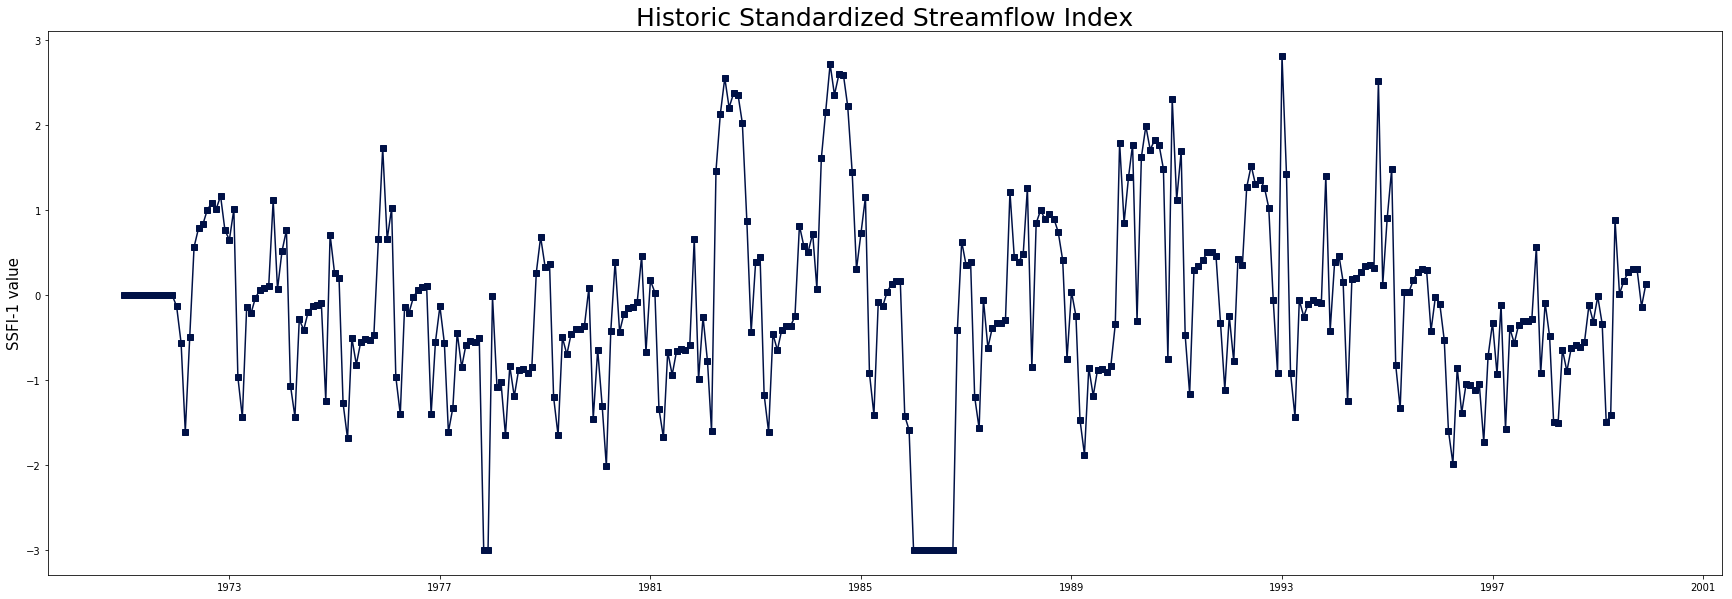

In [57]:
# 6.V Plot the calculated SSFI values over time
fig = plt.figure(figsize=(30,10) )
plt.plot(dates[h_in:h_out],SSFI1,"-s",color='#001146')
plt.ylabel('SSFI-1 value',size=15)
plt.title('Historic Standardized Streamflow Index',size=25)
plt.show()

### 6b: SSFI-6 calculation for each month over the historic time-period 

Do the same exercise for SSFI-6. Fill in the code-boxes 6b.I-6b.V to calculate SSFI-6 and plot the results. Save the plot and copy the results into the Word-Answer sheet under Figure 10. 

$Marthe: again delete the code-lines in the following code-boxes so that the students can come up with it themselves.

In [58]:
# 6b.I Extract historic data
hist_dataseries = variables['discharge'][h_in:h_out]    

In [59]:
# 6b.II Create an empty file to store SSFI-6 results
SSFI6 = np.zeros(hist_dataseries.shape)

In [60]:
# 6b.III Define the accumulation time-period and create a time-series of accumulated data
accumulationtime = 6   
cummuldata = np.cumsum(hist_dataseries, dtype=float)                 
cummuldata[accumulationtime:] = cummuldata[accumulationtime:] - cummuldata[:-accumulationtime]         
cummuldata[:accumulationtime - 1] = np.nan                                           
cummul_hist_dataseries = cummuldata  

In [61]:
# 6b.IV loop over all months to calculate SSFI-6 per month
for m in range(12):
    
    # Extract values per month, ignore first, incomplete year
    values = np.zeros(years_h-1)
    for yr in range(1,years_h):     
        values[yr-1] = cummul_hist_dataseries[(12*yr)+m]

    # Find distribution parameters of Gamma function      
    dist = getattr(stats, 'gamma')
    param = dist.fit(values)
    rv = dist(*param)   
    
    # Solve issue with zero values in Gamma distribution (cfr.Stagge et al. 2015)  
    nyears_zero = len(values) - np.count_nonzero(values)
    p_zero = nyears_zero / len(values)
    p_zero_mean = (nyears_zero + 1) / (2 * (len(values) + 1))           
    ppd = (values * 0 ) + p_zero_mean
    ppd[np.nonzero(values)] = p_zero+((1-p_zero)*rv.cdf(values[np.nonzero(values)]))
    
    # Standardize the cummulative distribution function
    z = stats.norm.ppf(ppd)                                   
    z[z>3] = 3
    z[z<-3] = -3 
    
    # Bring the SSFI values back in their right spot in the time series
    for yr in range(1,years_h):
        SSFI6[(12*yr)+m] = z[yr-1]   

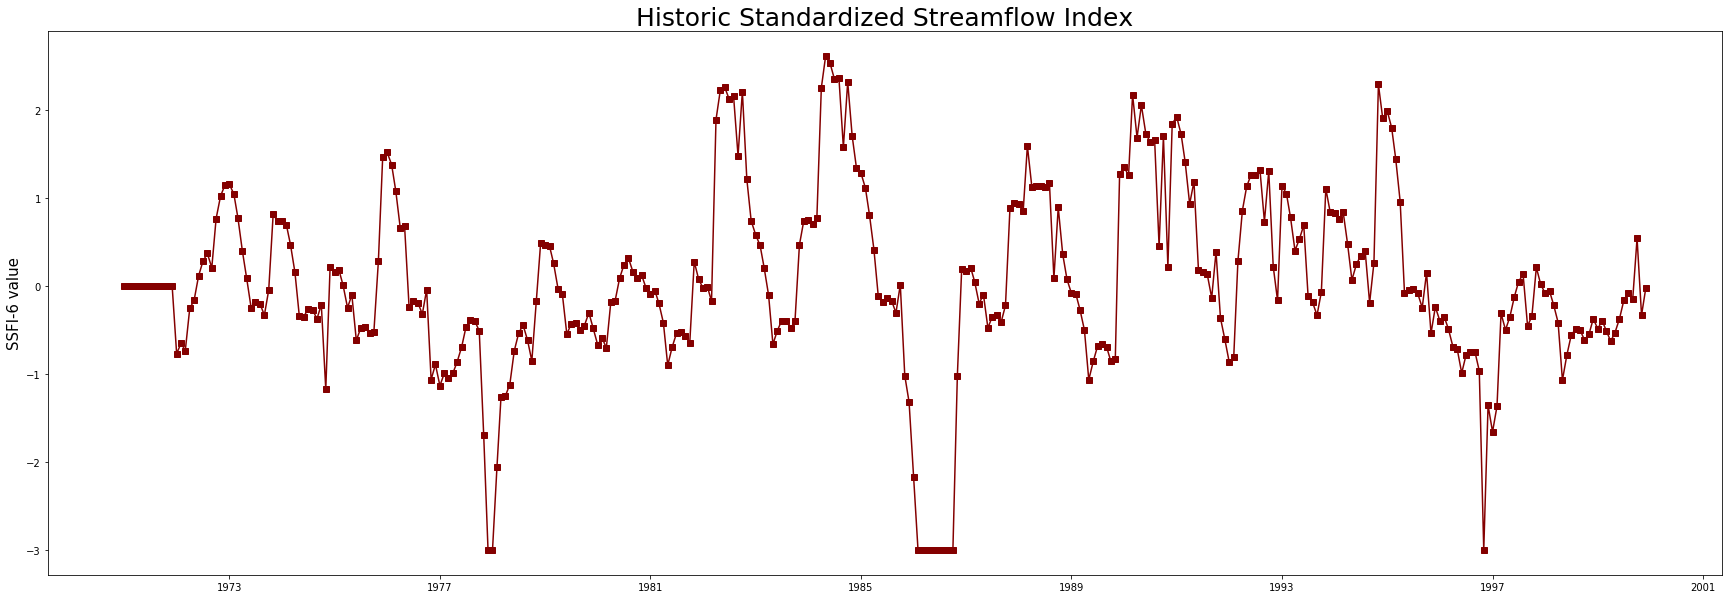

In [62]:
# 6b.V Plot the calculated SSFI-6 values over time
fig = plt.figure(figsize=(30,10) )
plt.plot(dates[h_in:h_out],SSFI6,"-s",color='#840000')
plt.ylabel('SSFI-6 value',size=15)
plt.title('Historic Standardized Streamflow Index',size=25)
plt.show()

## 7: Evaluate historical meteorological, agricultural, and hydrological  drought conditions 

Run the scripts in the code-boxes below to gerenate the plots. Inspect what happens to the plots when you change the threshold value for drought conditions. Save the generated plots under Figure 11 and 12 in the Word-Answer sheet.

In [63]:
# Define drought threshold over which droughts are being identified
threshold = -1 
thresholds = SPI1 * 0 + threshold

In [64]:
# Identify droughts
dSPI1 = np.zeros(SPI1.shape)
dSPI1[SPI1<threshold] = 1
dSPI6 = np.zeros(SPI6.shape)
dSPI6[SPI6<threshold] = 1

dSPEI1 = np.zeros(SPEI1.shape)
dSPEI1[SPEI1<threshold] = 1
dSPEI6 = np.zeros(SPEI6.shape)
dSPEI6[SPEI6<threshold] = 1

dSSFI1 = np.zeros(SSFI1.shape)
dSSFI1[SSFI1<threshold] = 1
dSSFI6 = np.zeros(SSFI6.shape)
dSSFI6[SSFI6<threshold] = 1

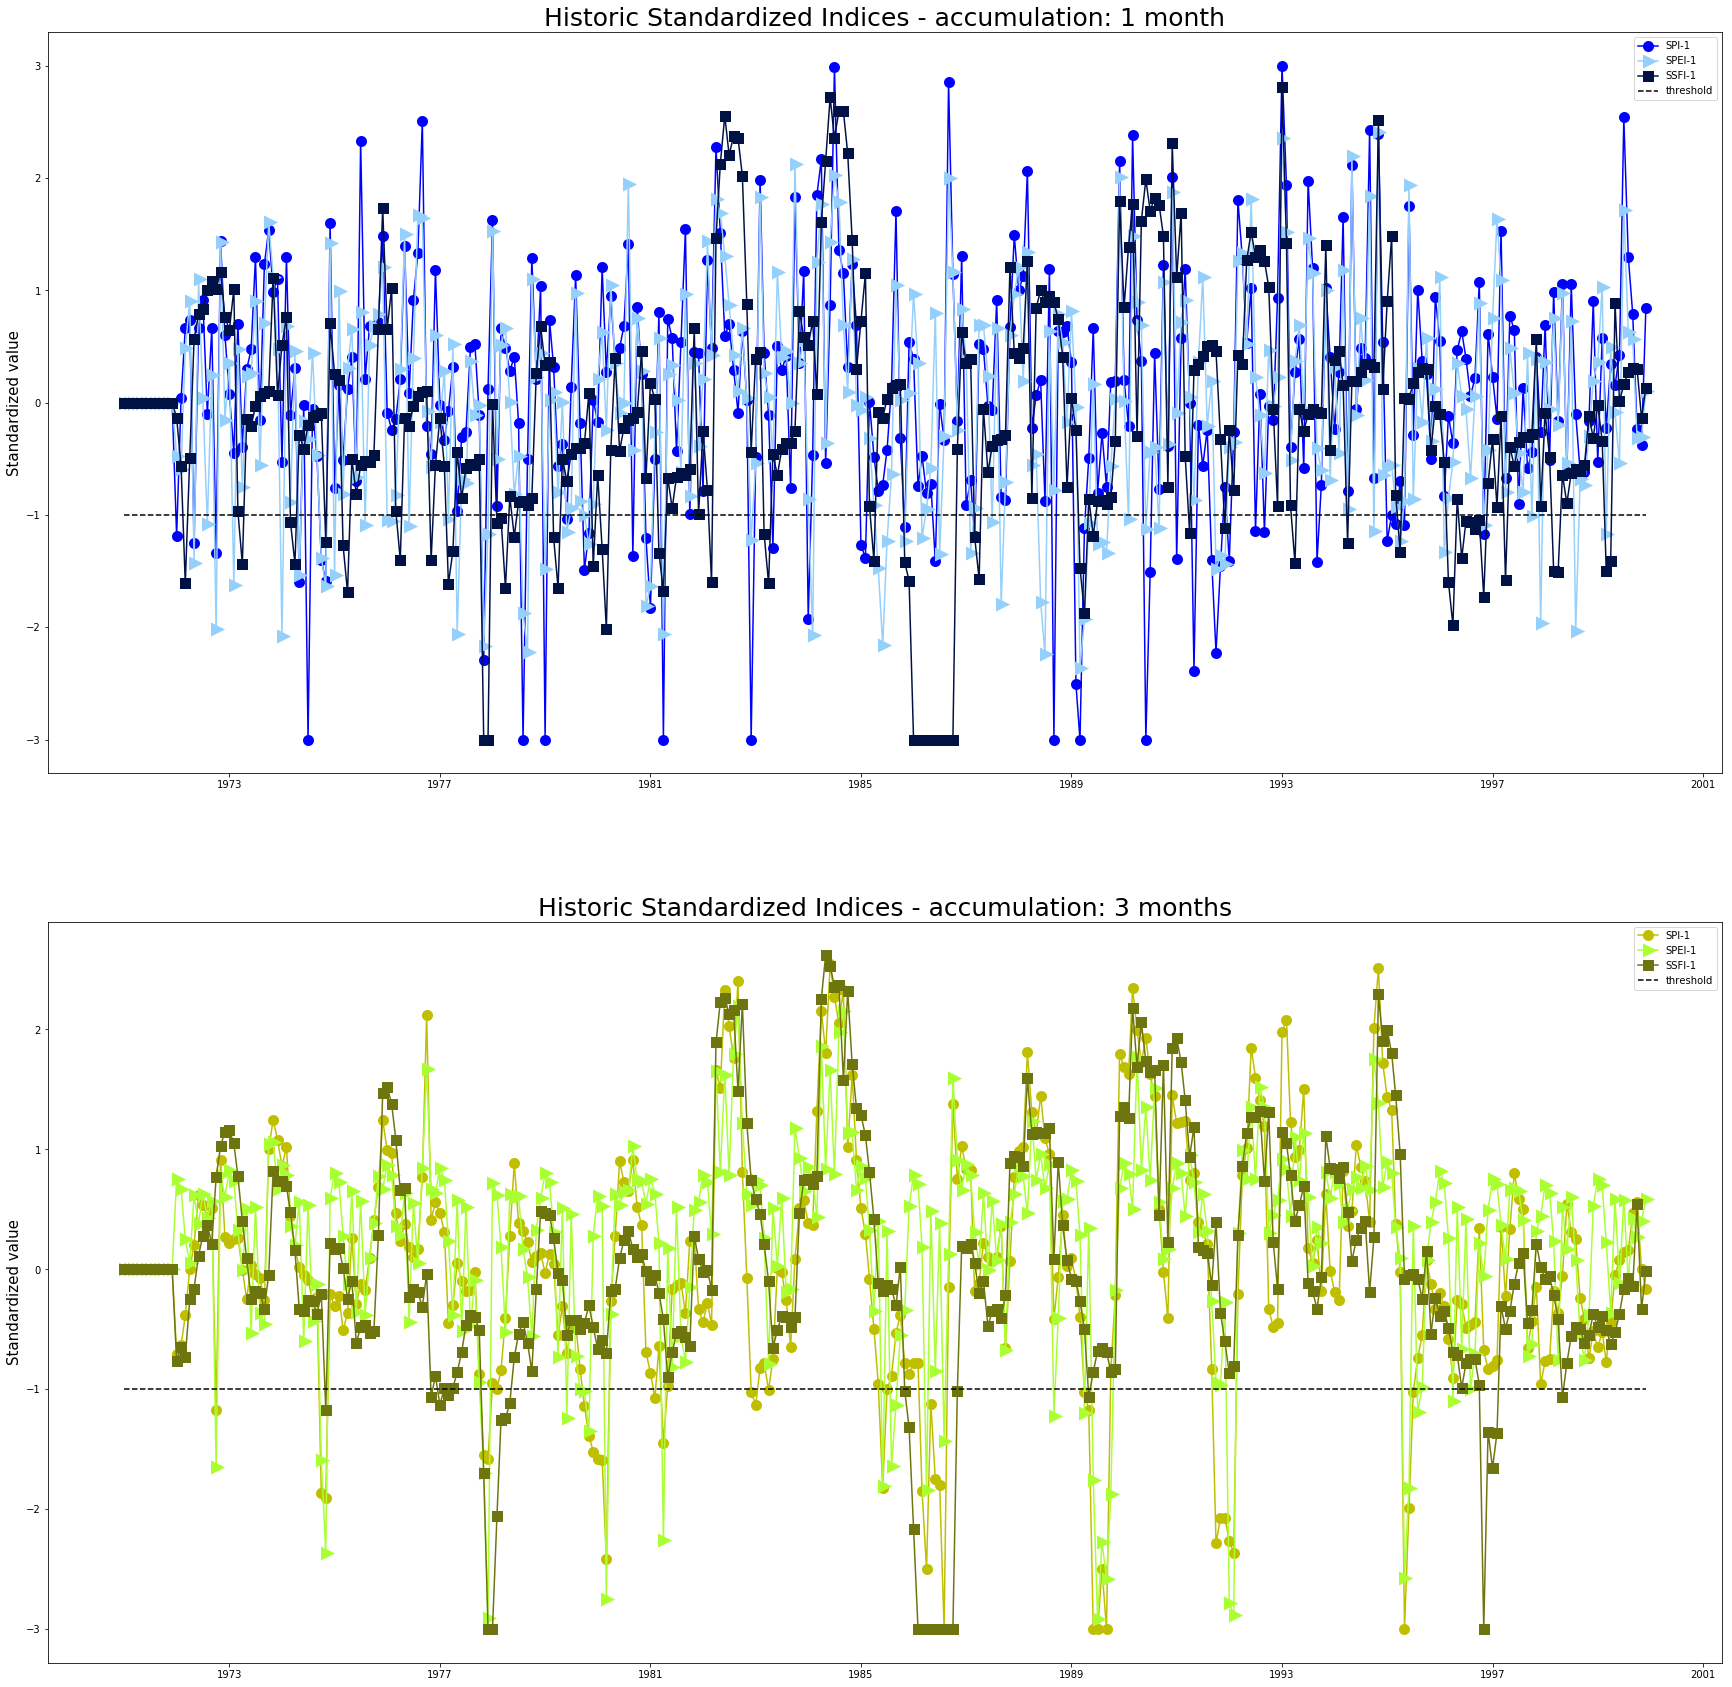

In [65]:
# Plot time-series of all indices and drought conditions
fig = plt.figure(figsize=(30,30) )

plt.subplot(2, 1, 1)
l1=plt.plot(dates[h_in:h_out],SPI1,"-o", color='b', mew=5, label='SPI-1')
l2=plt.plot(dates[h_in:h_out],SPEI1,"->", color='#95d0fc', mew=5, label='SPEI-1')
l3=plt.plot(dates[h_in:h_out],SSFI1,"-s", color='#001146', mew=5, label='SSFI-1')
l4=plt.plot(dates[h_in:h_out],thresholds,"--", color='k',label='threshold')
plt.ylabel('Standardized value',size=15)
plt.title('Historic Standardized Indices - accumulation: 1 month',size=25)
plt.legend()#(l1,l2,l3,l4), ('SPI-1', 'SPI-3', 'SPI-6','drought threshold'),'upper left')

plt.subplot(2, 1, 2)
l1=plt.plot(dates[h_in:h_out],SPI6,"-o", color='y', mew=5, label='SPI-1')
l2=plt.plot(dates[h_in:h_out],SPEI6,"->", color='#aaff32', mew=5, label='SPEI-1')
l3=plt.plot(dates[h_in:h_out],SSFI6,"-s", color='#6e750e', mew=5, label='SSFI-1')
l4=plt.plot(dates[h_in:h_out],thresholds,"--", color='k', mew=5, label='threshold')
plt.ylabel('Standardized value',size=15)
plt.title('Historic Standardized Indices - accumulation: 3 months',size=25)
plt.legend()#(l1,l2,l3,l4), ('SPI-1', 'SPI-3', 'SPI-6','drought threshold'),'upper left')

plt.show()

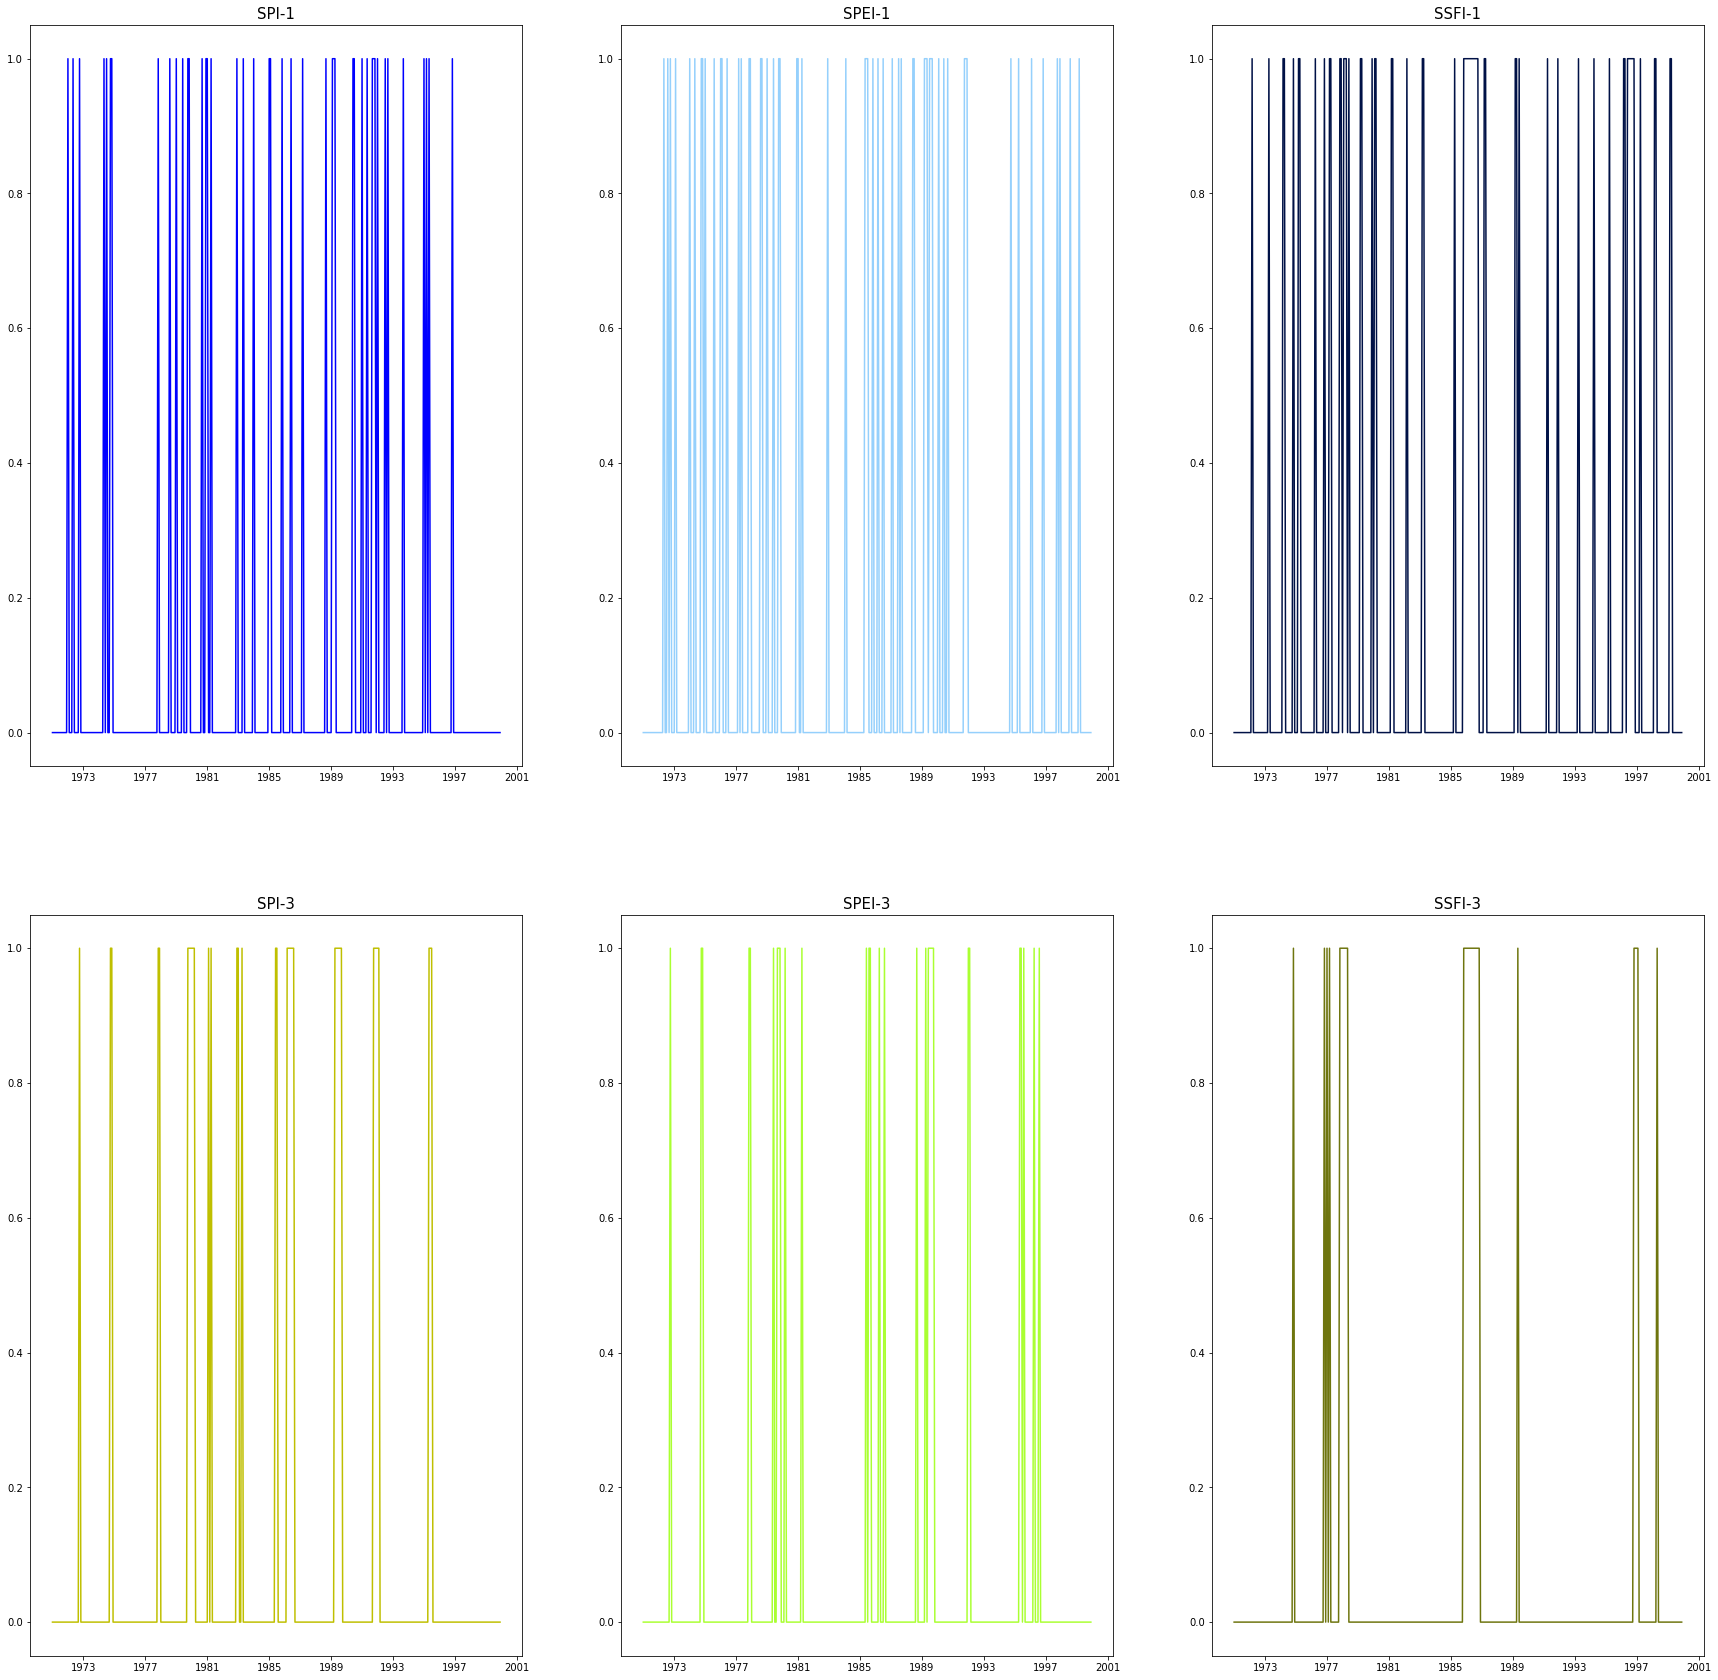

In [66]:
# Plot drought conditions of all indices and

fig = plt.figure(figsize=(30,30) )

plt.subplot(2, 3, 1)
l1=plt.plot(dates[h_in:h_out],dSPI1,"-", color='b', mew=5, label='SPI-1')
plt.title('SPI-1',size=15)
plt.subplot(2, 3, 2)
l2=plt.plot(dates[h_in:h_out],dSPEI1,"-", color='#95d0fc', mew=5, label='SPEI-1')
plt.title('SPEI-1',size=15)
plt.subplot(2, 3, 3)
l3=plt.plot(dates[h_in:h_out],dSSFI1,"-", color='#001146', mew=5, label='SSFI-1')
plt.title('SSFI-1',size=15)

plt.subplot(2, 3, 4)
l1=plt.plot(dates[h_in:h_out],dSPI6,"-", color='y', mew=5, label='SPI-3')
plt.title('SPI-3',size=15)
plt.subplot(2, 3, 5)
l2=plt.plot(dates[h_in:h_out],dSPEI6,"-", color='#aaff32', mew=5, label='SPEI-3')
plt.title('SPEI-3',size=15)
plt.subplot(2, 3, 6)
l3=plt.plot(dates[h_in:h_out],dSSFI6,"-", color='#6e750e', mew=5, label='SSFI-3')
plt.title('SSFI-3',size=15)

plt.show()

**Question 10**: When looking at figures 10 and 11, can you think of reasons why the SPI and SPEI are relatively similar while the SSFI looks quite different. Think of the hydrological processes that underlie the input data-sets of this different drought indicators.

## 8: Calculating hydrological drought conditions using the fixed and variable threshold level method over historical conditions
So far, we used standardized indicators to estimate meteorological, agricultural, and hydrological drought conditions (SPI, SPEI, SSFI). In this section. we will apply a fixed and variable threshold level (TL) method to assess hydrological droughts. An advantage of these TL methods is that the original hydrological values remain preserved and that it is relatively easier to estimate water shortages in absolute terms. Moreover, using these TL methods it is easier to assess changes in drought conditions under climate change. A disadvantage of the TL method is that these values are not standardized and that contextual information is needed to understand how ‘severe’ drought shortages are below the set threshold. Identification of drought months should be comparable, however, irregular of the methods used.

Inspect the code-boxes (8.I-8.VII) carefully, run them and save the results of under Table 2 for SSFI-1 threshold level of -1. 

**action**: Save the outcomes for SSFI-1 threshold level -1 under Table 2 in the Word-Answer sheet. 

In [67]:
# 8.I Define the height of the fixed monthly threshold level for discharge and estimate drought conditions
threshold_level_fixed = 10

Qthresholdf = np.nanpercentile(variables['discharge'][h_in:h_out],threshold_level_fixed)
dQf= np.zeros(variables['discharge'][h_in:h_out].shape)
dQf[variables['discharge'][h_in:h_out]<Qthresholdf] = 1

In [68]:
# 8.II Define the height of the variable monthly threshold level for discharge and estimate drought conditions
threshold_level_variable = 10

dQv= np.zeros(variables['discharge'][h_in:h_out].shape)
Qthresholdv = np.zeros(12) 
for m in range(12):
    
    # Extract values per month, then calculate threshold, then check when under threshold
    qt = np.zeros(years_h)
    for yr in range(years_h):     
        qt[yr] = variables['discharge'][h_in:h_out][(12*yr)+m]
    Qthresholdv[m] = np.nanpercentile(qt,threshold_level_variable)   
    for yr in range(years_h):
        if qt[yr] < Qthresholdv[m]:
            dQv[(12*yr)+m] = 1      

**Question 11**: If we would like to find the threshold levels for a Q80 instead of a Q90, where should we change parameters? Copy the line of code in your answer-sheet.

In [69]:
# 8.III Set a threshold for SSFI-1 and estimate drought conditions
threshold_level_SSFI1 = -1

ddSSFI1 = np.zeros(SSFI1.shape)
ddSSFI1[SSFI1<threshold_level_SSFI1] = 1

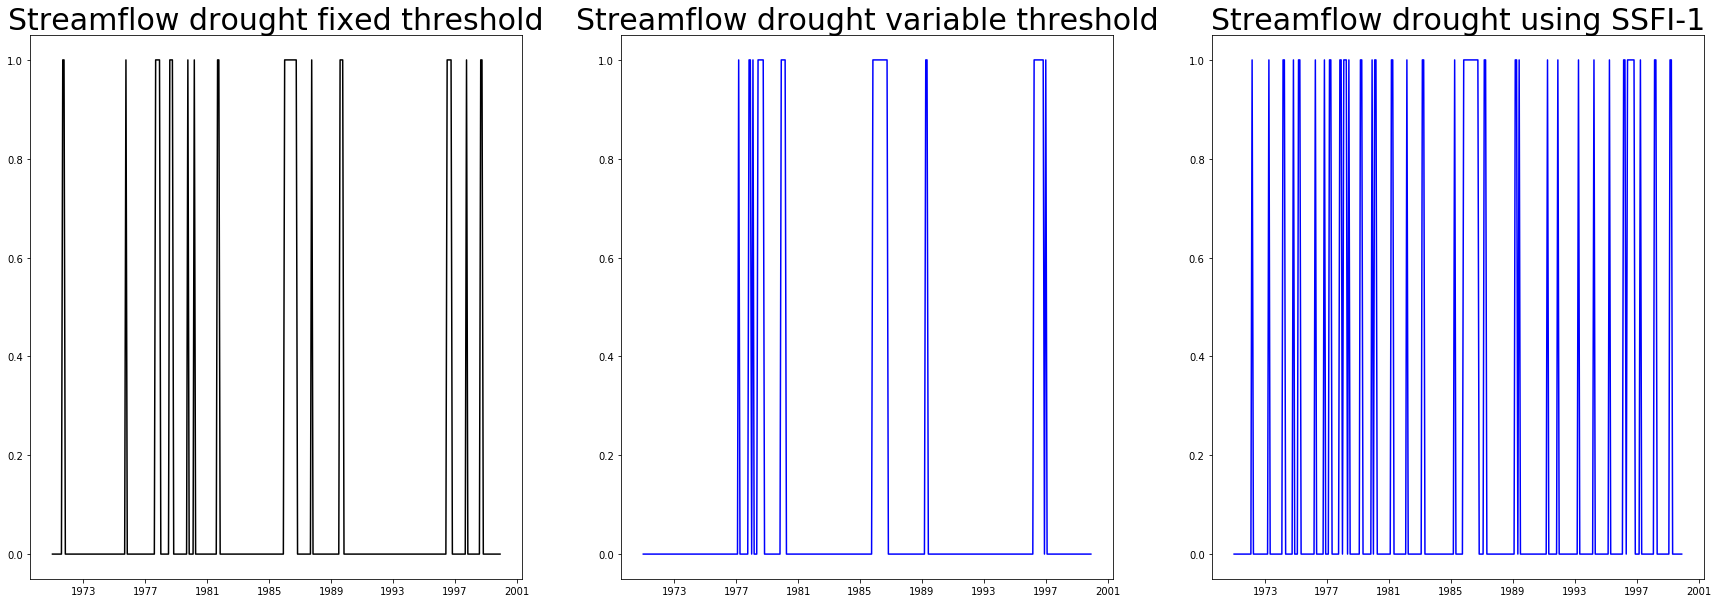

In [70]:
# 8.IV Plot the drought conditions as estimated with the fixed and variable threshold level method approach as well as with the SSFI-1

fig = plt.figure(figsize=(30,10) )

plt.subplot(1, 3, 1)
l1=plt.plot(dates[h_in:h_out],dQf,"-", color='k', mew=5)
plt.title('Streamflow drought fixed threshold',size=30)
plt.subplot(1, 3, 2)
l2=plt.plot(dates[h_in:h_out],dQv,"-", color='b', mew=5)
plt.title('Streamflow drought variable threshold',size=30)

plt.subplot(1, 3, 3)
l2=plt.plot(dates[h_in:h_out],ddSSFI1,"-", color='b', mew=5)
plt.title('Streamflow drought using SSFI-1', size=30)

plt.show()

**Question 12:** How does the occurrence of drought months and drought events differ between using a fixed and variable threshold method?

**Question 13**: How does the occurrence of drought months and drought events differ between using a fixed and variable threshold method?

In [71]:
# 8.V Analyse the total number of drought months using the fixed, variable and SSFI-1 threshold level method
print('fixed threshold')
print('number of months under historic Q drought conditions: ',np.sum(dQf))

print('variable threshold')
print('number of months under historic Q drought conditions: ',np.sum(dQv))

print('SSFI-1')
print('number of months under historic Q drought conditions: ',np.sum(ddSSFI1))


fixed threshold
number of months under historic Q drought conditions:  35.0
variable threshold
number of months under historic Q drought conditions:  36.0
SSFI-1
number of months under historic Q drought conditions:  63.0


In [72]:
# 8.VI Analyse the average duration of droughts under the fixed, variable and SSFI-I threshold level method
dQfpropagation = dQf * 0
dQvpropagation = dQv * 0
dQSSFIpropagation = ddSSFI1 * 0

for t in range(len(dQf)):
    if dQf[t] == 1:
        dQfpropagation[t] = dQfpropagation[t-1] + 1
        dQfpropagation[t-1] = 0
    else:
        dQfpropagation[t] = 0
    if dQv[t] == 1:
        dQvpropagation[t] = dQvpropagation[t-1] + 1
        dQvpropagation[t-1] = 0
    else:
        dQvpropagation[t] = 0
    if ddSSFI1[t] == 1:
        dQSSFIpropagation[t] = dQSSFIpropagation[t-1] + 1
        dQSSFIpropagation[t-1] = 0
    else:
        dQSSFIpropagation[t] = 0
print('historic average duration fixed threshold Q drought conditions: ',np.mean(dQfpropagation[dQfpropagation>0]),' months')
print('historic average duration variable threshold Q drought conditions: ',np.mean(dQvpropagation[dQvpropagation>0]),' months')
print('historic average duration SSFI-1 Q drought conditions: ',np.mean(dQSSFIpropagation[dQSSFIpropagation>0]),' months')


historic average duration fixed threshold Q drought conditions:  2.6923076923076925  months
historic average duration variable threshold Q drought conditions:  4.0  months
historic average duration SSFI-1 Q drought conditions:  1.96875  months


In [73]:
# 8.VII Analyse the total number of drought events under the fixed, variable and SSFI-I threshold level method
dQfpropagation[dQfpropagation>0] = 1
print('historic number of Q droughts - fixed threshold: ',np.sum(dQfpropagation))

dQvpropagation[dQvpropagation>0] = 1
print('historic number of Q droughts - variable threshold: ',np.sum(dQvpropagation))

dQSSFIpropagation[dQSSFIpropagation>0] = 1
print('historic number of Q droughts - SSFI: ',np.sum(dQSSFIpropagation))


historic number of Q droughts - fixed threshold:  13.0
historic number of Q droughts - variable threshold:  9.0
historic number of Q droughts - SSFI:  32.0


Try to find a threshold value for the SSFI-1 that best matches the drought conditions identified via the variable threshold level method by changing the SSFI threshold in code-box 8.III and repeatedly plotting the resulting graphs and statistics. Once you are satisfied save your graph and show it under Figure 12 in the Word-Answer sheet. Moreover report the final statistical values for the SSFI-1 drought conditions in Table 2. Together with the threshold-value level you ended up with. 

**action**: Find optimal SSFI-1 threshold level value to best resembles the results shown for the variable threshold level using a threshold of 10%. Save your result (figure, and statistical values) in the Word-Answer sheet under Table 2 and Figure 12.

## 9: Evaluate future drought conditions for meteorological and hydrological droughts

### 9a: Determine drought conditions under climate change scenario RCP2.6

Run the code-boxes (9a.I -9a.VI) to estimate the frequency, duration and total number of droughts under future conditions following the RCP2.6 scenario. 

**action**: Fill in the results under Table 3 in the Word-answer sheet.

In [74]:
# 9a.I Determine monthly fixed drought threshold level and estimate drought conditions - Precipitation
threshold_level_fixed = 10

Pthresholdf = np.nanpercentile(variables['precipitation'][h_in:h_out],threshold_level_fixed)
dPf= np.zeros(variables['precipitation'][h_in:h_out].shape)
dPf[variables['precipitation'][h_in:h_out]<Pthresholdf] = 1

Qthresholdf = np.nanpercentile(variables['discharge'][h_in:h_out],threshold_level_fixed)
dQf= np.zeros(variables['discharge'][h_in:h_out].shape)
dQf[variables['discharge'][h_in:h_out]<Qthresholdf] = 1

In [75]:
# 9a.II Determinde monthly variable drought threshold level and estimate drought conditions - Precipitation
threshold_level_variable = 10

PQv= np.zeros(variables['precipitation'][h_in:h_out].shape)
Pthresholdv = np.zeros(12) 
for m in range(12):
    
    # Extract values per month, then calculate threshold, then check when under threshold
    qt = np.zeros(years_h)
    for yr in range(years_h):     
        qt[yr] = variables['precipitation'][h_in:h_out][(12*yr)+m]
    Pthresholdv[m] = np.nanpercentile(qt,threshold_level_variable)   
    for yr in range(years_h):
        if qt[yr] < Pthresholdv[m]:
            PQv[(12*yr)+m] = 1  

dQv= np.zeros(variables['discharge'][h_in:h_out].shape)
Qthresholdv = np.zeros(12) 
for m in range(12):
    
    # Extract values per month, then calculate threshold, then check when under threshold
    qt = np.zeros(years_h)
    for yr in range(years_h):     
        qt[yr] = variables['discharge'][h_in:h_out][(12*yr)+m]
    Qthresholdv[m] = np.nanpercentile(qt,threshold_level_variable)   
    for yr in range(years_h):
        if qt[yr] < Qthresholdv[m]:
            dQv[(12*yr)+m] = 1   

In [76]:
# 9a.III Identify future droughts conditions under fixed conditions for meteorological and hydrological droughts
future_dPf= np.zeros(variables['precipitation'][f_in:f_out].shape)
future_dPf[variables['precipitation'][f_in:f_out]<Pthresholdf] = 1
future_dQf= np.zeros(variables['discharge'][f_in:f_out].shape)
future_dQf[variables['discharge'][f_in:f_out]<Qthresholdf] = 1


In [77]:
# 9a.IV Identify future droughts conditions under variable conditions for meteorological and hydrological droughts

future_dPv= np.zeros(variables['precipitation'][f_in:f_out].shape)
future_dQv= np.zeros(variables['discharge'][f_in:f_out].shape)
    
for m in range(12):
    
    # Extract values per month, then calculate threshold, then check when under threshold
    pt = np.zeros(years_f)
    qt = np.zeros(years_f)
    for yr in range(years_f):     
        pt[yr] = variables['precipitation'][f_in:f_out][(12*yr)+m]
        qt[yr] = variables['discharge'][f_in:f_out][(12*yr)+m]
  
    for yr in range(years_h):
        if pt[yr] < Pthresholdv[m]:
            future_dPv[(12*yr)+m] = 1  
        if qt[yr] < Qthresholdv[m]:
            future_dQv[(12*yr)+m] = 1      

In [78]:
# 9a.V Analyse the total number of drought months
print('fixed threshold')
print('# months Pr drought under future rcp2.6 conditions: ',np.sum(future_dPf))
print('# months Q drought under future rcp2.6 conditions: ',np.sum(future_dQf))
print('variable threshold')
print('# months Pr drought under future rcp2.6 conditions: ',np.sum(future_dPv))
print('# months Q drought under future rcp2.6 conditions: ',np.sum(future_dQv))

fixed threshold
# months Pr drought under future rcp2.6 conditions:  66.0
# months Q drought under future rcp2.6 conditions:  71.0
variable threshold
# months Pr drought under future rcp2.6 conditions:  36.0
# months Q drought under future rcp2.6 conditions:  36.0


In [79]:
# 9a.VI analyse the average duration of droughts 
future_dPfpropagation = future_dPf * 0
future_dPvpropagation = future_dPf * 0
for t in range(len(future_dPf)):
    if future_dPf[t] == 1:
        future_dPfpropagation[t] = future_dPfpropagation[t-1] + 1
        future_dPfpropagation[t-1] = 0
    else:
        future_dPfpropagation[t] = 0
    if future_dPv[t] == 1:
        future_dPvpropagation[t] = future_dPvpropagation[t-1] + 1
        future_dPvpropagation[t-1] = 0
    else:
        future_dPvpropagation[t] = 0
print('av. duration Pr drought under future rcp2.6 conditions - fixed threshold: ',np.mean(future_dPfpropagation[future_dPfpropagation>0]),' months')
print('av. duration Pr drought under future rcp2.6 conditions - variable threshold: ',np.mean(future_dPvpropagation[future_dPvpropagation>0]),' months')

future_dQfpropagation = future_dQf * 0
future_dQvpropagation = future_dQf * 0
for t in range(len(future_dQf)):
    if future_dQf[t] == 1:
        future_dQfpropagation[t] = future_dQfpropagation[t-1] + 1
        future_dQfpropagation[t-1] = 0
    else:
        future_dQfpropagation[t] = 0
    if future_dQv[t] == 1:
        future_dQvpropagation[t] = future_dQvpropagation[t-1] + 1
        future_dQvpropagation[t-1] = 0
    else:
        future_dQvpropagation[t] = 0
print('av. duration Q drought under future rcp2.6 conditions - fixed threshold: ',np.mean(future_dQfpropagation[future_dQfpropagation>0]),' months')
print('av. duration Q drought under future rcp2.6 conditions - variable threshold: ',np.mean(future_dQvpropagation[future_dQvpropagation>0]),' months')

av. duration Pr drought under future rcp2.6 conditions - fixed threshold:  1.1379310344827587  months
av. duration Pr drought under future rcp2.6 conditions - variable threshold:  1.2857142857142858  months
av. duration Q drought under future rcp2.6 conditions - fixed threshold:  3.0869565217391304  months
av. duration Q drought under future rcp2.6 conditions - variable threshold:  4.0  months


### 9b: Determine drought conditions under climate change scenario RCP6.0

Copy and amend the code from 9a.I-9a.iV into the code-boxes 9b.I -9b.IV and run it to estimate future drought conditions under the RCP6.0 scenario. Here: use 'variables2' instead of 'variables' to indicate the time-series for the RCP6.0 climate change scenario.

**action**: Copy and amend the code from 9a.I-9a.VI into 9b.I-9b.VI and replace variable for variable2.

$Marthe: Maak code-boxes 9b.I - 9b.IV leeg met uitzondering van de instructies

In [80]:
# 9b.I Determine monthly fixed drought threshold level and estimate drought conditions
threshold_level_fixed = 10

Pthresholdf = np.nanpercentile(variables2['precipitation'][h_in:h_out],threshold_level_fixed)
dPf= np.zeros(variables2['precipitation'][h_in:h_out].shape)
dPf[variables2['precipitation'][h_in:h_out]<Pthresholdf] = 1

Qthresholdf = np.nanpercentile(variables2['discharge'][h_in:h_out],threshold_level_fixed)
dQf= np.zeros(variables2['discharge'][h_in:h_out].shape)
dQf[variables2['discharge'][h_in:h_out]<Qthresholdf] = 1

In [81]:
# 9b.II Determinde monthly variable drought threshold level and estimate drought conditions
threshold_level_variable = 10

PQv= np.zeros(variables2['precipitation'][h_in:h_out].shape)
Pthresholdv = np.zeros(12) 
for m in range(12):
    
    # Extract values per month, then calculate threshold, then check when under threshold
    qt = np.zeros(years_h)
    for yr in range(years_h):     
        qt[yr] = variables2['precipitation'][h_in:h_out][(12*yr)+m]
    Pthresholdv[m] = np.nanpercentile(qt,threshold_level_variable)   
    for yr in range(years_h):
        if qt[yr] < Pthresholdv[m]:
            PQv[(12*yr)+m] = 1  

dQv= np.zeros(variables2['discharge'][h_in:h_out].shape)
Qthresholdv = np.zeros(12) 
for m in range(12):
    
    # Extract values per month, then calculate threshold, then check when under threshold
    qt = np.zeros(years_h)
    for yr in range(years_h):     
        qt[yr] = variables2['discharge'][h_in:h_out][(12*yr)+m]
    Qthresholdv[m] = np.nanpercentile(qt,threshold_level_variable)   
    for yr in range(years_h):
        if qt[yr] < Qthresholdv[m]:
            dQv[(12*yr)+m] = 1   

In [82]:
# 9b.III Identify future droughts conditions under fixed conditions for meteorological and hydrological droughts
future_dPf= np.zeros(variables2['precipitation'][f_in:f_out].shape)
future_dPf[variables2['precipitation'][f_in:f_out]<Pthresholdf] = 1
future_dQf= np.zeros(variables2['discharge'][f_in:f_out].shape)
future_dQf[variables2['discharge'][f_in:f_out]<Qthresholdf] = 1


In [83]:
# 9b.IV Identify future droughts conditions under variable conditions for meteorological and hydrological droughts

future_dPv= np.zeros(variables2['precipitation'][f_in:f_out].shape)
future_dQv= np.zeros(variables2['discharge'][f_in:f_out].shape)
    
for m in range(12):
    
    # Extract values per month, then calculate threshold, then check when under threshold
    pt = np.zeros(years_f)
    qt = np.zeros(years_f)
    for yr in range(years_f):     
        pt[yr] = variables2['precipitation'][f_in:f_out][(12*yr)+m]
        qt[yr] = variables2['discharge'][f_in:f_out][(12*yr)+m]
  
    for yr in range(years_h):
        if pt[yr] < Pthresholdv[m]:
            future_dPv[(12*yr)+m] = 1  
        if qt[yr] < Qthresholdv[m]:
            future_dQv[(12*yr)+m] = 1      

Run the code-boxes 9b.V-9b.VI to estimate the frequency, duration and total number of droughts under future conditions following the RCP6.0 climate change scenario. 

**action**: Fill in the results under Table 3 in the Word-answer sheet. 

In [84]:
# 9b.V Analyse the total number of drought months
print('fixed threshold')
print('# months Pr drought under future rcp6.0 conditions: ',np.sum(future_dPf))
print('# months Q drought under future rcp6.0 conditions: ',np.sum(future_dQf))
print('variable threshold')
print('# months Pr drought under future rcp6.0 conditions: ',np.sum(future_dPv))
print('# months Q drought under future rcp6.0 conditions: ',np.sum(future_dQv))

fixed threshold
# months Pr drought under future rcp6.0 conditions:  77.0
# months Q drought under future rcp6.0 conditions:  100.0
variable threshold
# months Pr drought under future rcp6.0 conditions:  36.0
# months Q drought under future rcp6.0 conditions:  36.0


In [85]:
# 9b.VI analyse the average duration of droughts 
future_dPfpropagation = future_dPf * 0
future_dPvpropagation = future_dPf * 0
for t in range(len(future_dPf)):
    if future_dPf[t] == 1:
        future_dPfpropagation[t] = future_dPfpropagation[t-1] + 1
        future_dPfpropagation[t-1] = 0
    else:
        future_dPfpropagation[t] = 0
    if future_dPv[t] == 1:
        future_dPvpropagation[t] = future_dPvpropagation[t-1] + 1
        future_dPvpropagation[t-1] = 0
    else:
        future_dPvpropagation[t] = 0
print('av. duration Pr drought under future rcp6.0 conditions - fixed threshold: ',np.mean(future_dPfpropagation[future_dPfpropagation>0]),' months')
print('av. duration Pr drought under future rcp6.0 conditions - variable threshold: ',np.mean(future_dPvpropagation[future_dPvpropagation>0]),' months')

future_dQfpropagation = future_dQf * 0
future_dQvpropagation = future_dQf * 0
for t in range(len(future_dQf)):
    if future_dQf[t] == 1:
        future_dQfpropagation[t] = future_dQfpropagation[t-1] + 1
        future_dQfpropagation[t-1] = 0
    else:
        future_dQfpropagation[t] = 0
    if future_dQv[t] == 1:
        future_dQvpropagation[t] = future_dQvpropagation[t-1] + 1
        future_dQvpropagation[t-1] = 0
    else:
        future_dQvpropagation[t] = 0
print('av. duration Q drought under future rcp6.0 conditions - fixed threshold: ',np.mean(future_dQfpropagation[future_dQfpropagation>0]),' months')
print('av. duration Q drought under future rcp6.0 conditions - variable threshold: ',np.mean(future_dQvpropagation[future_dQvpropagation>0]),' months')


av. duration Pr drought under future rcp6.0 conditions - fixed threshold:  1.2419354838709677  months
av. duration Pr drought under future rcp6.0 conditions - variable threshold:  1.2857142857142858  months
av. duration Q drought under future rcp6.0 conditions - fixed threshold:  4.0  months
av. duration Q drought under future rcp6.0 conditions - variable threshold:  4.0  months


**Question 14**: Using your results produced under section 9, discuss in ~500 words how the different climate change scenarios influence the occurrence and characteristics of hydrological drought for this particular point in Kenya. Link your results with outcomes of recent research (scientific literature) 